![uc3m](http://materplat.org/wp-content/uploads/LogoUC3M.jpg)



### Automatic recognition of emotions evoked by soundscapes


### Gonzalo Lencina Lorenzon






#### Required installations:

In [49]:
!pip install librosa
!pip install xgboost
!pip install keras
!pip install tensorflow
!pip install GPy 

#### Required Python libraries 

In [2]:
import os

#Models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import GPy
from tensorflow import keras
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import  Conv2D, MaxPooling2D

#Metrics

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Utils
from IPython.display import display
import librosa.display
import numpy  as np
import matplotlib.pyplot as plt
import librosa  # package for speech and audio analysis
import pylab as pl
import pandas as pd
import time
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, ShuffleSplit

#Configuration
%config InlineBackend.figure_format = 'retina'   


### Data reading and preproccesing

In [3]:

XData = pd.read_csv ( 'Emo-Soundscapes/Emo-Soundscapes/Emo-Soundscapes-Features/Normalized_Features.csv')
Yvalence = pd.read_csv ( 'Emo-Soundscapes/Emo-Soundscapes/Emo-Soundscapes-Ratings/Valence.csv', header = None )
Yarousal = pd.read_csv ( 'Emo-Soundscapes/Emo-Soundscapes/Emo-Soundscapes-Ratings/Arousal.csv' , header = None )


XData = XData.iloc[: , 1:XData.shape[1] ]

Audio_descriptors = Yarousal.iloc[: , 0:1 ]

Yarousal = Yarousal.iloc[: , 0:Yarousal.shape[1] ]
Yvalence = Yvalence.iloc[: , 0:Yvalence.shape[1] ]

Audio_descriptors = np.squeeze(np.asarray(Audio_descriptors))
Yarousal = np.squeeze(np.asarray(Yarousal))
Yvalence = np.squeeze(np.asarray(Yvalence))


#We eliminated features whose variance is lower than a threshold (0.02).
selector = VarianceThreshold(0.02)
selector.fit(XData)
mask = selector.get_support()

XData = XData.iloc[:,mask]

print(XData.shape)


(1213, 39)


In [52]:
XData

,eventdensity_mean,rolloff_mean,brightness_mean,centroid_std,spread_mean,flatness_mean,flatness_std,entropy_mean,entropy_std,mfcc_std_2,...,chromagram_mean_5,chromagram_mean_7,chromagram_mean_8,chromagram_mean_9,chromagram_mean_11,chromagram_mean_12,chromagram_std_8,chromagram_std_10,chromagram_std_11,loudness_std
0,0.180149,0.128489,0.256286,0.069339,0.115824,0.046742,0.114604,0.572988,0.182889,0.231397,...,0.650703,0.516265,0.506205,0.527391,0.797281,0.791344,0.513498,0.449157,0.486863,0.347576
1,0.180149,0.156579,0.271329,0.133305,0.223017,0.112771,0.308073,0.595437,0.216400,0.243295,...,0.649825,0.515449,0.506335,0.530010,0.796419,0.792756,0.516932,0.447301,0.488677,0.240593
2,0.180149,0.140393,0.260993,0.115822,0.132058,0.061556,0.162629,0.578357,0.193066,0.232527,...,0.652551,0.516615,0.505802,0.528960,0.798092,0.792756,0.512669,0.447040,0.486936,0.344449
3,0.340900,0.292328,0.558156,0.063163,0.243513,0.158336,0.097748,0.752684,0.144103,0.296433,...,0.636725,0.473267,0.471187,0.503577,0.834520,0.822293,0.489018,0.430336,0.425687,0.199390
4,0.843000,0.297361,0.576993,0.058414,0.231721,0.134789,0.093007,0.757732,0.105054,0.296142,...,0.639163,0.477792,0.473568,0.505110,0.833537,0.823170,0.490705,0.425609,0.430076,0.277877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,1.000000,0.564615,0.588964,0.204170,0.527218,0.359908,0.239261,0.838132,0.225938,0.101033,...,0.401331,0.492202,0.290399,0.293265,0.656118,0.563865,0.474276,0.560775,0.667863,0.258196
1209,1.000000,0.286410,0.332642,0.289175,0.288548,0.118223,0.160326,0.634844,0.288524,0.058296,...,0.574194,0.328898,0.546225,0.670761,0.900242,0.799646,0.475756,0.428770,0.357107,0.311533
1210,1.000000,0.152356,0.259379,0.022200,0.147617,0.078857,0.057308,0.569206,0.155608,0.051029,...,0.550848,0.443577,0.406154,0.472930,0.822124,0.816456,0.454917,0.476764,0.464942,0.659042
1211,1.000000,0.172034,0.385884,0.037419,0.115945,0.063492,0.025904,0.653602,0.113103,0.050295,...,0.782788,0.587894,0.569965,0.573270,0.754720,0.768170,0.470842,0.437238,0.472617,0.404539


In [21]:
Kfolds_cv = ShuffleSplit(n_splits=10, test_size=.20, random_state=42)
Kfolds_cv2 = ShuffleSplit(n_splits=10, test_size=.20, random_state=42)

## SVR:

In [4]:
YvalenceSVR = pd.DataFrame(Yvalence) 
YarousalSVR = pd.DataFrame(Yarousal) 

#Define the params grids to search
param_grid_valence_SVR = [
                       {'kernel': ['rbf'], 'gamma': [ 5,3,2,1.5, 1,0.9,0.8,0.7,0.6,0.5,0.4,0.3, 1e-1], 
                        'C': [0.1,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,5]}
                     ]
param_grid_arousal_SVR = [
                       {'kernel': ['rbf'], 'gamma': [10, 1,0.5,0.4,0.3,0.2,0.1,0.05,0.01,1e-2], 
                        'C': [5,6,7,8,9,10,11,12,13,14,15]}
                     ]

### SVR with the 39 selected features

In [43]:

#Arrays to store the results for each of the folds
R2_valence_SVR_AllF = []
MSE_valence_SVR_AllF = []
R2_arousal_SVR_AllF = []
MSE_arousal_SVR_AllF = []

Feature_importance_train_valence_SVR = []
Feature_importance_test_valence_SVR = []
Feature_importance_train_arousal_SVR = []
Feature_importance_test_arousal_SVR = []
iteration = 0
start = time.time()

for train_index, test_index in Kfolds_cv2.split(XData):

    print("ITERATION: " , iteration)
    
    X_train_SVR, X_test_SVR = XData.iloc[ train_index , :], XData.iloc[ test_index , : ]
    y_train_valence_SVR, y_test_valence_SVR = YvalenceSVR.iloc[train_index,:],  YvalenceSVR.iloc[test_index , :]
    y_train_arousal_SVR, y_test_arousal_SVR = YarousalSVR.iloc[train_index,:],  YarousalSVR.iloc[test_index, :]
    
    print("Train set shape:")
    print(X_train_SVR.shape)
    print("Test set shape:")
    print(X_test_SVR.shape)

    #VALENCE
    CV_SVR_valence = GridSearchCV( estimator = SVR() , param_grid=param_grid_valence_SVR, 
                                  cv= Kfolds_cv , n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_SVR_valence.fit(X_train_SVR, y_train_valence_SVR.iloc[:,1] )

    SVR_final_valence = CV_SVR_valence.best_estimator_

    SVR_y_predicted_valence = SVR_final_valence.predict(X_test_SVR)

    result_valence_test = permutation_importance(SVR_final_valence, X_test_SVR, y_test_valence_SVR.iloc[:,1], 
                                                 n_repeats=40, random_state=42, n_jobs=-1, scoring = "r2")
    result_valence_train = permutation_importance(SVR_final_valence, X_train_SVR, y_train_valence_SVR.iloc[:,1], 
                                                  n_repeats=40, random_state=42, n_jobs=-1, scoring = "r2")
    
    Feature_importance_train_valence_SVR.append(result_valence_train.importances_mean)
    Feature_importance_test_valence_SVR.append(result_valence_test.importances_mean)
    
    R2score = r2_score(y_test_valence_SVR.iloc[:,1] , SVR_y_predicted_valence)
    MSEscore = mean_squared_error( y_test_valence_SVR.iloc[:,1] , SVR_y_predicted_valence)
    
    MSE_valence_SVR_AllF.append( MSEscore )
    R2_valence_SVR_AllF.append( R2score )
    
    print('Best params: {} '.format( CV_SVR_valence.best_params_))
    print("R2 score: " , R2score)

    #AROUSAL
    CV_SVR_arousal = GridSearchCV( estimator = SVR() , param_grid=param_grid_arousal_SVR,
                                  cv= Kfolds_cv ,  n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_SVR_arousal.fit(X_train_SVR, y_train_arousal_SVR.iloc[:,1] )

    SVR_final_arousal = CV_SVR_arousal.best_estimator_

    SVR_y_predicted_arousal = SVR_final_arousal.predict(X_test_SVR)

    result_arousal_test = permutation_importance(SVR_final_arousal, X_test_SVR, y_test_arousal_SVR.iloc[:,1], 
                                                 n_repeats=40, random_state=42, n_jobs=-1, scoring = "r2")
    result_arousal_train = permutation_importance(SVR_final_arousal, X_train_SVR, y_train_arousal_SVR.iloc[:,1], 
                                                  n_repeats=40, random_state=42, n_jobs=-1, scoring = "r2")
    
    Feature_importance_train_arousal_SVR.append(result_arousal_train.importances_mean)
    Feature_importance_test_arousal_SVR.append(result_arousal_test.importances_mean)
    
    R2score = r2_score(y_test_arousal_SVR.iloc[:,1] , SVR_y_predicted_arousal)
    MSEscore = mean_squared_error(y_test_arousal_SVR.iloc[:,1] , SVR_y_predicted_arousal)
    
    MSE_arousal_SVR_AllF.append(MSEscore)
    R2_arousal_SVR_AllF.append(R2score)
    
    print('Best params: {} '.format( CV_SVR_arousal.best_params_))
    print("R2 score: " , R2score)
    iteration = iteration +1
    
print("Time (minutes):")
print((time.time()-start)/60)
print("\n")

ITERATION:  0
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   22.2s finished


Best params: {'C': 1.4, 'gamma': 0.8, 'kernel': 'rbf'} 
R2 score:  0.6313078651487881
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   16.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   16.5s finished


Best params: {'C': 5, 'gamma': 0.3, 'kernel': 'rbf'} 
R2 score:  0.8867759955091213
ITERATION:  1
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   22.0s finished


Best params: {'C': 1.3, 'gamma': 0.7, 'kernel': 'rbf'} 
R2 score:  0.6656386957983937
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   16.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   16.6s finished


Best params: {'C': 8, 'gamma': 0.2, 'kernel': 'rbf'} 
R2 score:  0.8630664163352594
ITERATION:  2
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   21.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   21.8s finished


Best params: {'C': 0.8, 'gamma': 0.7, 'kernel': 'rbf'} 
R2 score:  0.6489895283285446
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   16.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   16.4s finished


Best params: {'C': 6, 'gamma': 0.2, 'kernel': 'rbf'} 
R2 score:  0.8938077381297233
ITERATION:  3
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   22.0s finished


Best params: {'C': 1.1, 'gamma': 0.4, 'kernel': 'rbf'} 
R2 score:  0.6259864388697705
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   16.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   16.6s finished


Best params: {'C': 5, 'gamma': 0.2, 'kernel': 'rbf'} 
R2 score:  0.8558181034006875
ITERATION:  4
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   21.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   21.9s finished


Best params: {'C': 1.2, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.6467354028610783
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   16.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   16.6s finished


Best params: {'C': 8, 'gamma': 0.2, 'kernel': 'rbf'} 
R2 score:  0.9006664044637691
ITERATION:  5
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   21.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   21.8s finished


Best params: {'C': 0.7, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.6635157185836125
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   16.5s finished


Best params: {'C': 8, 'gamma': 0.2, 'kernel': 'rbf'} 
R2 score:  0.8618210480702275
ITERATION:  6
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   21.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   21.8s finished


Best params: {'C': 1, 'gamma': 0.7, 'kernel': 'rbf'} 
R2 score:  0.6183687840496823
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   16.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   16.6s finished


Best params: {'C': 15, 'gamma': 0.1, 'kernel': 'rbf'} 
R2 score:  0.8757151782868835
ITERATION:  7
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   21.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   21.9s finished


Best params: {'C': 0.9, 'gamma': 0.9, 'kernel': 'rbf'} 
R2 score:  0.716780336641726
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   16.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   16.7s finished


Best params: {'C': 15, 'gamma': 0.1, 'kernel': 'rbf'} 
R2 score:  0.8514964600757328
ITERATION:  8
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   21.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   22.0s finished


Best params: {'C': 1.5, 'gamma': 0.8, 'kernel': 'rbf'} 
R2 score:  0.6643798507638371
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   16.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   16.4s finished


Best params: {'C': 9, 'gamma': 0.1, 'kernel': 'rbf'} 
R2 score:  0.8511979565010033
ITERATION:  9
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   21.8s finished


Best params: {'C': 0.8, 'gamma': 0.6, 'kernel': 'rbf'} 
R2 score:  0.7006100633883469
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   16.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   16.6s finished


Best params: {'C': 5, 'gamma': 0.3, 'kernel': 'rbf'} 
R2 score:  0.870025813395834
Time (minutes):
11.630872046947479




In [44]:
print("Valence R2 SVR: {0:.3f}".format(np.mean(R2_valence_SVR_AllF)) + " std: {0:.3f}".format(np.std(R2_valence_SVR_AllF)))
print("Arousal R2 SVR: {0:.3f}".format(np.mean(R2_arousal_SVR_AllF)) + " std: {0:.3f}".format(np.std(R2_arousal_SVR_AllF)))

print("Valence MSE SVR: {0:.3f}".format(np.mean(MSE_valence_SVR_AllF)) + " std: {0:.3f}".format(np.std(MSE_valence_SVR_AllF)))
print("Arousal MSE SVR: {0:.3f}".format(np.mean(MSE_arousal_SVR_AllF)) + " std: {0:.3f}".format(np.std(MSE_arousal_SVR_AllF)))

Valence R2 SVR: 0.658 std: 0.030
Arousal R2 SVR: 0.871 std: 0.017
Valence MSE SVR: 0.111 std: 0.009
Arousal MSE SVR: 0.042 std: 0.006


In [12]:
#Function to compute the average permutation feature importance of the partitions for each feature
def compute_feature_importance_of_folds(feature_importance_folds):
    feature_importance = []
    for i in range(np.shape(feature_importance_folds)[1]):
        add = 0
        for j in range(np.shape(feature_importance_folds)[0]):
            add = add + feature_importance_folds[j][i]
        feature_importance.append(add/(np.shape(feature_importance_folds)[0]))
    return feature_importance


final_feature_importance_train_valence_SVR = np.array(compute_feature_importance_of_folds(Feature_importance_train_valence_SVR))
final_feature_importance_test_valence_SVR = np.array(compute_feature_importance_of_folds(Feature_importance_test_valence_SVR))
final_feature_importance_train_arousal_SVR = np.array(compute_feature_importance_of_folds(Feature_importance_train_arousal_SVR))
final_feature_importance_test_arousal_SVR = np.array(compute_feature_importance_of_folds(Feature_importance_test_arousal_SVR))

print(final_feature_importance_train_valence_SVR.shape)
print(final_feature_importance_train_valence_SVR)

NameError: name 'Feature_importance_train_valence_SVR' is not defined

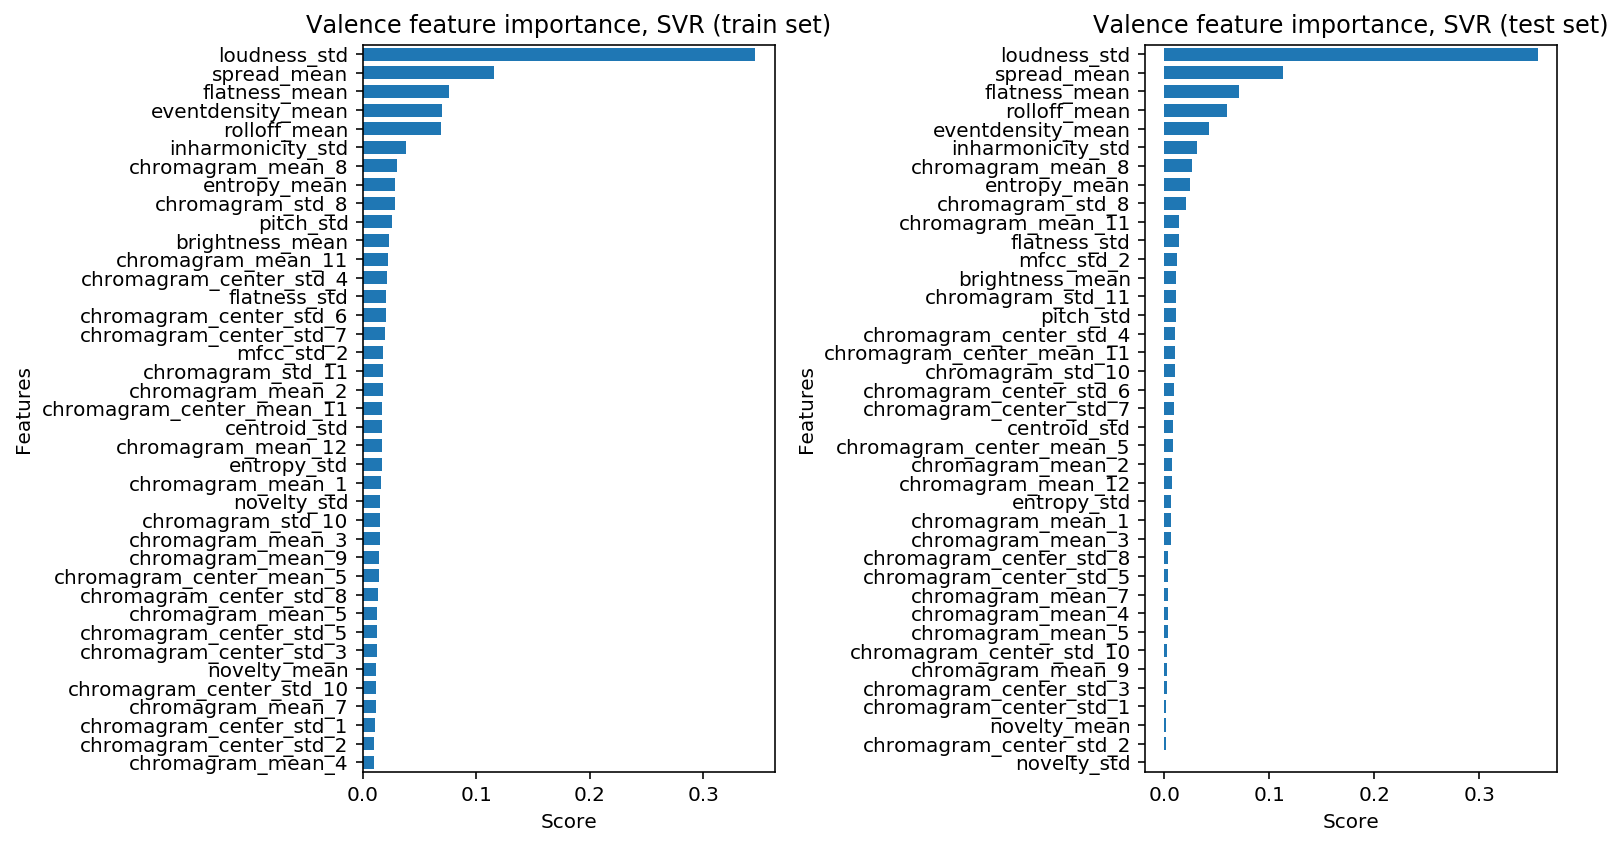

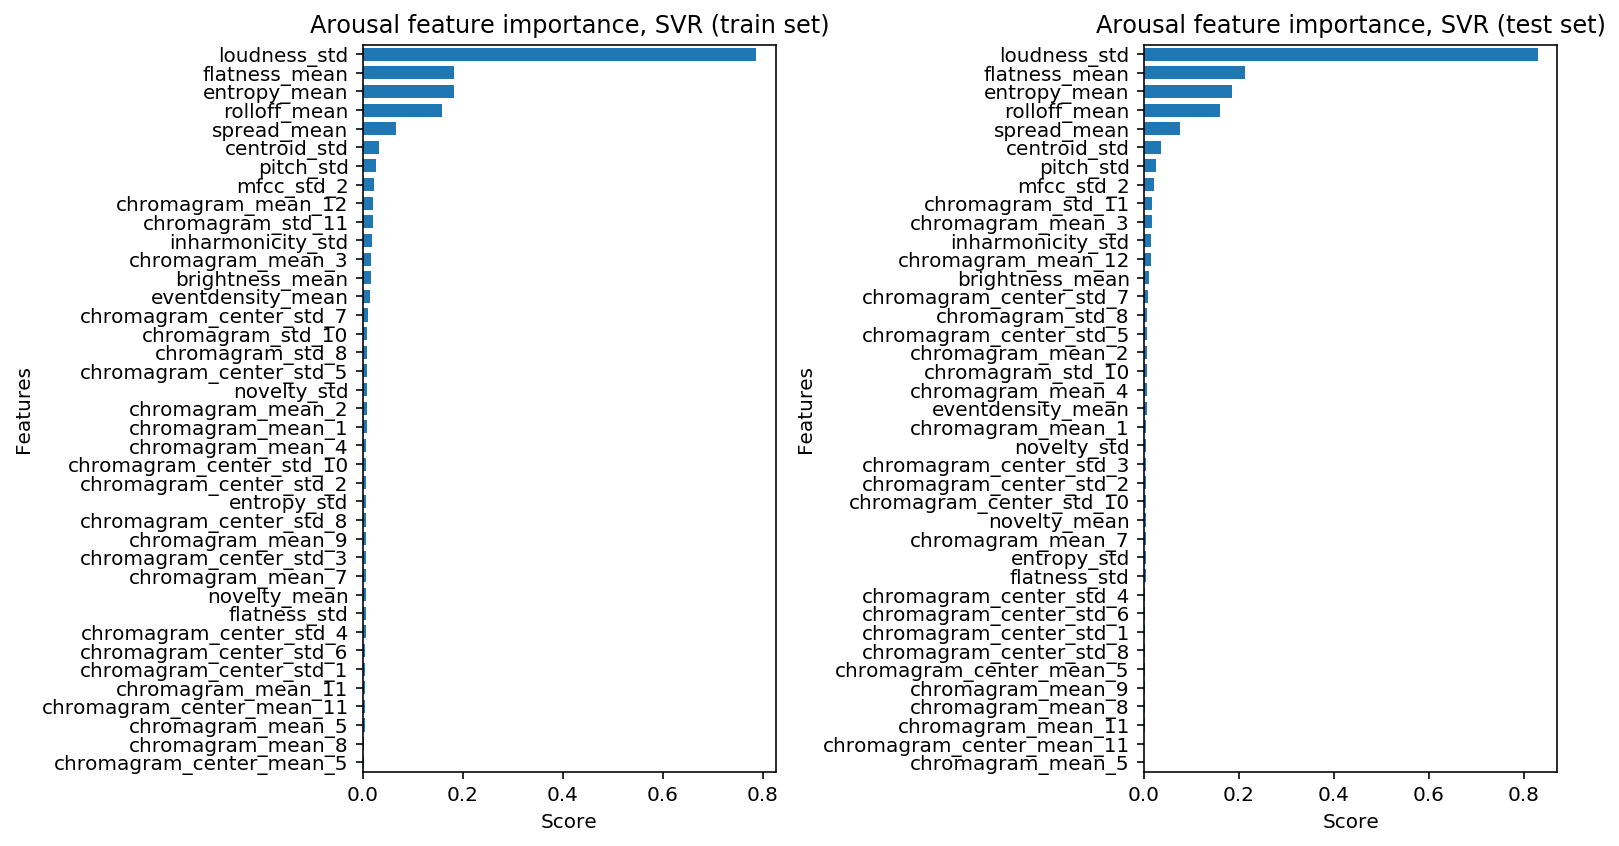

In [17]:
importance_sorted_idx_train_valence_SVR = np.argsort(final_feature_importance_train_valence_SVR)
indices_train_valence_SVR = np.arange(0, len(final_feature_importance_train_valence_SVR)) + 0.5

importance_sorted_idx_test_valence_SVR = np.argsort(final_feature_importance_test_valence_SVR)
indices_test_valence_SVR = np.arange(0, len(final_feature_importance_test_valence_SVR)) + 0.5


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(11, 6))
ax1.barh(indices_train_valence_SVR,
         final_feature_importance_train_valence_SVR[importance_sorted_idx_train_valence_SVR], height=0.7)

ax1.set_yticklabels(XData.columns[importance_sorted_idx_train_valence_SVR])
ax1.set_yticks(indices_train_valence_SVR)
ax1.set_ylim((0, len(final_feature_importance_train_valence_SVR)))
ax1.set_ylabel("Features")
ax1.set_xlabel("Score")
ax1.set_title("Valence feature importance, SVR (train set)")

ax2.barh(indices_test_valence_SVR,
         final_feature_importance_test_valence_SVR[importance_sorted_idx_test_valence_SVR], height=0.7)
ax2.set_yticklabels(XData.columns[importance_sorted_idx_test_valence_SVR])
ax2.set_yticks(indices_test_valence_SVR)
ax2.set_ylim((0, len(final_feature_importance_test_valence_SVR)))
ax2.set_ylabel("Features")
ax2.set_xlabel("Score")
ax2.set_title("Valence feature importance, SVR (test set)")
fig.tight_layout()
plt.show()

importance_sorted_idx_train_arousal_SVR = np.argsort(final_feature_importance_train_arousal_SVR)
indices_train_arousal_SVR = np.arange(0, len(final_feature_importance_train_arousal_SVR)) + 0.5

importance_sorted_idx_test_arousal_SVR = np.argsort(final_feature_importance_test_arousal_SVR)
indices_test_arousal_SVR = np.arange(0, len(final_feature_importance_test_arousal_SVR)) + 0.5

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(11, 6))
ax1.barh(indices_train_arousal_SVR,
         final_feature_importance_train_arousal_SVR[importance_sorted_idx_train_arousal_SVR], height=0.7)

ax1.set_yticklabels(XData.columns[importance_sorted_idx_train_arousal_SVR])
ax1.set_yticks(indices_train_arousal_SVR)
ax1.set_ylim((0, len(final_feature_importance_train_arousal_SVR)))
ax1.set_ylabel("Features")
ax1.set_xlabel("Score")
ax1.set_title("Arousal feature importance, SVR (train set)")

ax2.barh(indices_test_arousal_SVR,
         final_feature_importance_test_arousal_SVR[importance_sorted_idx_test_arousal_SVR], height=0.7)
ax2.set_yticklabels(XData.columns[importance_sorted_idx_test_arousal_SVR])
ax2.set_yticks(indices_test_arousal_SVR)
ax2.set_ylim((0, len(final_feature_importance_test_arousal_SVR)))
ax2.set_ylabel("Features")
ax2.set_xlabel("Score")
ax2.set_title("Arousal feature importance, SVR (test set)")
fig.tight_layout()
plt.show()

The subsets of the most important features are created based on the results of the previous graphs:

In [18]:
XData_10_features_valence_SVR = ['loudness_std','spread_mean','flatness_mean',
                        'rolloff_mean', 'eventdensity_mean', 'inharmonicity_std',
                        'chromagram_mean_8','entropy_mean','chromagram_std_8','chromagram_mean_11'
                        ]

XData_5_features_valence_SVR = ['loudness_std','spread_mean','flatness_mean',
                        'rolloff_mean','eventdensity_mean']

XData_10_features_arousal_SVR = ['loudness_std','flatness_mean','entropy_mean',
                        'rolloff_mean', 'spread_mean', 'centroid_std', 'pitch_std',
                        'mfcc_std_2','chromagram_std_11','chromagram_mean_3']

XData_5_features_arousal_SVR = ['loudness_std','flatness_mean','entropy_mean',
                        'rolloff_mean','spread_mean']


### SVR with the 10 most important features

In [19]:


#This time the same process will be executed but in the 10 most important features only

R2_valence_SVR_10F = []
MSE_valence_SVR_10F = []
R2_arousal_SVR_10F = []
MSE_arousal_SVR_10F = []

start = time.time()
iteration= 0
for train_index, test_index in Kfolds_cv2.split(XData):

    print("ITERATION: ",iteration)
    
    X_train_SVR, X_test_SVR = XData.iloc[train_index,:], XData.iloc[test_index,:]
    
    X_train_valence_SVR, X_test_valence_SVR = X_train_SVR.loc[:,XData_10_features_valence_SVR], X_test_SVR.loc[:,XData_10_features_valence_SVR]
    X_train_arousal_SVR, X_test_arousal_SVR = X_train_SVR.loc[:,XData_10_features_arousal_SVR], X_test_SVR.loc[:,XData_10_features_arousal_SVR]
    
    y_train_valence_SVR, y_test_valence_SVR = YvalenceSVR.iloc[train_index,:],  YvalenceSVR.iloc[test_index , :]
    y_train_arousal_SVR, y_test_arousal_SVR = YarousalSVR.iloc[train_index,:],  YarousalSVR.iloc[test_index, :]
    
    print("X train valence shape: " , X_train_valence_SVR.shape)
    print("X test valence shape: " , X_test_valence_SVR.shape)
    print("X train arousal shape: " , X_train_arousal_SVR.shape)
    print("X test arousal shape: " , X_test_arousal_SVR.shape)
    
    
    #VALENCE
    CV_SVR_valence = GridSearchCV( estimator = SVR() , param_grid=param_grid_valence_SVR, 
                                  cv= Kfolds_cv , n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_SVR_valence.fit(X_train_valence_SVR, y_train_valence_SVR.iloc[:,1] )

    SVR_final_valence = CV_SVR_valence.best_estimator_

    SVR_y_predicted_valence = SVR_final_valence.predict(X_test_valence_SVR)

    R2score = r2_score(y_test_valence_SVR.iloc[:,1] , SVR_y_predicted_valence)
    MSEscore = mean_squared_error( y_test_valence_SVR.iloc[:,1] , SVR_y_predicted_valence)
    
    MSE_valence_SVR_10F.append(MSEscore)
    R2_valence_SVR_10F.append(R2score)
    
    print('Best params: {} '.format( CV_SVR_valence.best_params_))
    print("R2 score: " , R2score)

    #AROUSAL
    CV_SVR_arousal = GridSearchCV( estimator = SVR() , param_grid=param_grid_arousal_SVR,
                                  cv= Kfolds_cv ,  n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_SVR_arousal.fit(X_train_arousal_SVR, y_train_arousal_SVR.iloc[:,1] )

    SVR_final_arousal = CV_SVR_arousal.best_estimator_

    SVR_y_predicted_arousal = SVR_final_arousal.predict(X_test_arousal_SVR)

    R2score = r2_score(y_test_arousal_SVR.iloc[:,1] , SVR_y_predicted_arousal)
    MSEscore = mean_squared_error(y_test_arousal_SVR.iloc[:,1] , SVR_y_predicted_arousal)
    
    MSE_arousal_SVR_10F.append(MSEscore)
    R2_arousal_SVR_10F.append(R2score)
    
    print('Best params: {} '.format( CV_SVR_arousal.best_params_))
    print("R2 score: " , R2score)
    iteration = iteration +1
    
print("Time (minutes):")
print((time.time()-start)/60)
print("\n")


ITERATION:  0
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.6, 'gamma': 3, 'kernel': 'rbf'} 
R2 score:  0.6271726728502602
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   10.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 11, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.8887954845503451
ITERATION:  1
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.7, 'gamma': 3, 'kernel': 'rbf'} 
R2 score:  0.6494199886837407
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   10.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   10.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 13, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.8999772255382453
ITERATION:  2
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   14.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.8, 'gamma': 3, 'kernel': 'rbf'} 
R2 score:  0.6488472426827923
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 15, 'gamma': 0.5, 'kernel': 'rbf'} 
R2 score:  0.9027198881374064
ITERATION:  3
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.6, 'gamma': 3, 'kernel': 'rbf'} 
R2 score:  0.6151634229888461
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   11.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 6, 'gamma': 0.5, 'kernel': 'rbf'} 
R2 score:  0.8830410107934971
ITERATION:  4
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.6, 'gamma': 3, 'kernel': 'rbf'} 
R2 score:  0.6454269232527519
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   12.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   12.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 9, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.9008436123783892
ITERATION:  5
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1653 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.5, 'gamma': 3, 'kernel': 'rbf'} 
R2 score:  0.6385106678608656
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   11.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   11.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 5, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.9024294968020972
ITERATION:  6
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   15.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.6, 'gamma': 3, 'kernel': 'rbf'} 
R2 score:  0.5968072879102297
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 13, 'gamma': 0.5, 'kernel': 'rbf'} 
R2 score:  0.910480492580727
ITERATION:  7
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   15.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.6, 'gamma': 5, 'kernel': 'rbf'} 
R2 score:  0.6678891611417146
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   12.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   12.2s finished


Best params: {'C': 7, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.879255068389852
ITERATION:  8
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1653 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.8, 'gamma': 3, 'kernel': 'rbf'} 
R2 score:  0.6740025571479309
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   11.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 9, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.8846073362458792
ITERATION:  9
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   15.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.6, 'gamma': 3, 'kernel': 'rbf'} 
R2 score:  0.692308112124092
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    8.9s


Best params: {'C': 15, 'gamma': 0.5, 'kernel': 'rbf'} 
R2 score:  0.8838011566443035
Time (minutes):
4.497106011708578




[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:   11.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:   11.5s finished


In [20]:
print("Valence R2 SVR: {0:.3f}".format(np.mean(R2_valence_SVR_10F)) + " std: {0:.3f}".format(np.std(R2_valence_SVR_10F)))
print("Arousal R2 SVR: {0:.3f}".format(np.mean(R2_arousal_SVR_10F)) + " std: {0:.3f}".format(np.std(R2_arousal_SVR_10F)))

print("Valence MSE SVR: {0:.3f}".format(np.mean(MSE_valence_SVR_10F)) + " std: {0:.3f}".format(np.std(MSE_valence_SVR_10F)))
print("Arousal MSE SVR: {0:.3f}".format(np.mean(MSE_arousal_SVR_10F)) + " std: {0:.3f}".format(np.std(MSE_arousal_SVR_10F)))

Valence R2 SVR: 0.646 std: 0.027
Arousal R2 SVR: 0.894 std: 0.010
Valence MSE SVR: 0.115 std: 0.008
Arousal MSE SVR: 0.035 std: 0.004


### SVR with the 5 most important features

In [21]:

#This time the same process will be executed but in the 5 most important features only
R2_valence_SVR_5F = []
MSE_valence_SVR_5F = []
R2_arousal_SVR_5F = []
MSE_arousal_SVR_5F = []

start = time.time()
iteration= 0

for train_index, test_index in Kfolds_cv2.split(XData):

    print("ITERATION: ",iteration)
    
    X_train_SVR, X_test_SVR = XData.iloc[train_index,:], XData.iloc[test_index,:]
    
    X_train_valence_SVR, X_test_valence_SVR = X_train_SVR.loc[:,XData_5_features_valence_SVR], X_test_SVR.loc[:,XData_5_features_valence_SVR]
    X_train_arousal_SVR, X_test_arousal_SVR = X_train_SVR.loc[:,XData_5_features_arousal_SVR], X_test_SVR.loc[:,XData_5_features_arousal_SVR]
    
    y_train_valence_SVR, y_test_valence_SVR = YvalenceSVR.iloc[train_index,:],  YvalenceSVR.iloc[test_index , :]
    y_train_arousal_SVR, y_test_arousal_SVR = YarousalSVR.iloc[train_index,:],  YarousalSVR.iloc[test_index, :]
    
    print("X train valence shape: " , X_train_valence_SVR.shape)
    print("X test valence shape: " , X_test_valence_SVR.shape)
    print("X train arousal shape: " , X_train_arousal_SVR.shape)
    print("X test arousal shape: " , X_test_arousal_SVR.shape)
    
    
    #VALENCE
    CV_SVR_valence = GridSearchCV( estimator = SVR() , param_grid=param_grid_valence_SVR, 
                                  cv= Kfolds_cv , n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_SVR_valence.fit(X_train_valence_SVR, y_train_valence_SVR.iloc[:,1] )

    SVR_final_valence = CV_SVR_valence.best_estimator_

    SVR_y_predicted_valence = SVR_final_valence.predict(X_test_valence_SVR)

    R2score = r2_score(y_test_valence_SVR.iloc[:,1] , SVR_y_predicted_valence)
    MSEscore = mean_squared_error( y_test_valence_SVR.iloc[:,1] , SVR_y_predicted_valence)
    
    MSE_valence_SVR_5F.append(MSEscore)
    R2_valence_SVR_5F.append(R2score)
    
    print('Best params: {} '.format( CV_SVR_valence.best_params_))
    print("R2 score: " , R2score)

    #AROUSAL
    CV_SVR_arousal = GridSearchCV( estimator = SVR() , param_grid=param_grid_arousal_SVR,
                                  cv= Kfolds_cv ,  n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_SVR_arousal.fit(X_train_arousal_SVR, y_train_arousal_SVR.iloc[:,1] )

    SVR_final_arousal = CV_SVR_arousal.best_estimator_

    SVR_y_predicted_arousal = SVR_final_arousal.predict(X_test_arousal_SVR)

    R2score = r2_score(y_test_arousal_SVR.iloc[:,1] , SVR_y_predicted_arousal)
    MSEscore = mean_squared_error(y_test_arousal_SVR.iloc[:,1] , SVR_y_predicted_arousal)
    
    MSE_arousal_SVR_5F.append(MSEscore)
    R2_arousal_SVR_5F.append(R2score)
    
    print('Best params: {} '.format( CV_SVR_arousal.best_params_))
    print("R2 score: " , R2score)
    iteration = iteration +1
    
print("Time (minutes):")
print((time.time()-start)/60)
print("\n")

ITERATION:  0
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 5, 'gamma': 2, 'kernel': 'rbf'} 
R2 score:  0.57295528994926
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 15, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.8824706738399748
ITERATION:  1
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.8, 'gamma': 5, 'kernel': 'rbf'} 
R2 score:  0.5570314732527959
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 15, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.8848987771401595
ITERATION:  2
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 1.2, 'gamma': 5, 'kernel': 'rbf'} 
R2 score:  0.5204459374337198
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1085 out of 1100 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 15, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.9088718940585969
ITERATION:  3
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.6, 'gamma': 5, 'kernel': 'rbf'} 
R2 score:  0.5580315754858403
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 15, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.8616722018350511
ITERATION:  4
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   13.5s finished


Best params: {'C': 0.7, 'gamma': 5, 'kernel': 'rbf'} 
R2 score:  0.6083233301956088
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 15, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.897036418272649
ITERATION:  5
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1653 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.8, 'gamma': 5, 'kernel': 'rbf'} 
R2 score:  0.5785235131473401
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1064 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    9.4s finished


Best params: {'C': 15, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.881453718057401
ITERATION:  6
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 1.1, 'gamma': 3, 'kernel': 'rbf'} 
R2 score:  0.5085095382392153
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 15, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.8944681018777902
ITERATION:  7
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 1675 out of 1690 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.7, 'gamma': 5, 'kernel': 'rbf'} 
R2 score:  0.6429966118994858
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 15, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.8518053751947844
ITERATION:  8
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1653 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 0.8, 'gamma': 3, 'kernel': 'rbf'} 
R2 score:  0.6454800923172449
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 15, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.8684367581859854
ITERATION:  9
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 169 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params: {'C': 1.1, 'gamma': 5, 'kernel': 'rbf'} 
R2 score:  0.6248516957325508
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.2s


Best params: {'C': 15, 'gamma': 1, 'kernel': 'rbf'} 
R2 score:  0.8786169957126533
Time (minutes):
3.795955542723338




[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed:    9.0s finished


In [22]:
print("Valence R2 SVR: {0:.3f}".format(np.mean(R2_valence_SVR_5F)) + " std: {0:.3f}".format(np.std(R2_valence_SVR_5F)))
print("Arousal R2 SVR: {0:.3f}".format(np.mean(R2_arousal_SVR_5F)) + " std: {0:.3f}".format(np.std(R2_arousal_SVR_5F)))

print("Valence MSE SVR: {0:.3f}".format(np.mean(MSE_valence_SVR_5F)) + " std: {0:.3f}".format(np.std(MSE_valence_SVR_5F)))
print("Arousal MSE SVR: {0:.3f}".format(np.mean(MSE_arousal_SVR_5F)) + " std: {0:.3f}".format(np.std(MSE_arousal_SVR_5F)))

Valence R2 SVR: 0.582 std: 0.046
Arousal R2 SVR: 0.881 std: 0.016
Valence MSE SVR: 0.136 std: 0.011
Arousal MSE SVR: 0.039 std: 0.006


## RF:

In [23]:
YvalenceRF = pd.DataFrame(Yvalence) 
YarousalRF = pd.DataFrame(Yarousal) 
param_grid_valence_RF = {
    'bootstrap': [True],
    'max_depth': [ 100, 110,120],
    'max_features': [  5, 6, 7],
    'min_samples_leaf': [1,2, 3],
    'min_samples_split': [3,4,5],
    'n_estimators': [1500, 2000,300]
}
param_grid_arousal_RF = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70],
    'max_features': [5, 6, 7],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [5,6,7],
    'n_estimators': [ 100,200, 300]
}


### RF with the 39 selected features

In [24]:

R2_valence_RF_AllF = []
MSE_valence_RF_AllF = []
R2_arousal_RF_AllF = []
MSE_arousal_RF_AllF = []
Feature_importance_train_valence_RF = []
Feature_importance_test_valence_RF = []
Feature_importance_train_arousal_RF = []
Feature_importance_test_arousal_RF = []
start = time.time()
iteration = 0

for train_index, test_index in Kfolds_cv2.split(XData):

 
    print("ITERATION: " , iteration)
    
    X_train_RF, X_test_RF = XData.iloc[ train_index , :], XData.iloc[ test_index , : ]
    y_train_valence_RF, y_test_valence_RF = YvalenceRF.iloc[train_index,:],  YvalenceRF.iloc[test_index , :]
    y_train_arousal_RF, y_test_arousal_RF = YarousalRF.iloc[train_index,:],  YarousalRF.iloc[test_index, :]
    
    print("Train set shape:")
    print(X_train_RF.shape)
    print("Test set shape:")
    print(X_test_RF.shape)
    
    #VALENCE
    CV_RF_valence = GridSearchCV( estimator = RandomForestRegressor() , param_grid=param_grid_valence_RF, 
                                  cv= Kfolds_cv , n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_RF_valence.fit(X_train_RF, y_train_valence_RF.iloc[:,1] )

    RF_final_valence = CV_RF_valence.best_estimator_

    RF_y_predicted_valence = RF_final_valence.predict(X_test_RF)

    result_valence_test = permutation_importance(RF_final_valence, X_test_RF, y_test_valence_RF.iloc[:,1], 
                                                 n_repeats=40, random_state=42, n_jobs=-1, scoring = "r2")
    result_valence_train = permutation_importance(RF_final_valence, X_train_RF, y_train_valence_RF.iloc[:,1], 
                                                  n_repeats=40, random_state=42, n_jobs=-1, scoring = "r2")
    
    Feature_importance_train_valence_RF.append(result_valence_train.importances_mean)
    Feature_importance_test_valence_RF.append(result_valence_test.importances_mean)
    
    R2score = r2_score(y_test_valence_RF.iloc[:,1] , RF_y_predicted_valence)
    MSEscore = mean_squared_error( y_test_valence_RF.iloc[:,1] , RF_y_predicted_valence) 
    MSE_valence_RF_AllF.append(MSEscore)
    R2_valence_RF_AllF.append(R2score)
    
    print('Best params: {} '.format(CV_RF_valence.best_params_))
    print("R2 score: " , R2score)
    
    #AROUSAL
    CV_RF_arousal = GridSearchCV( estimator = RandomForestRegressor() , param_grid=param_grid_arousal_RF,
                                  cv= Kfolds_cv ,  n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_RF_arousal.fit(X_train_RF, y_train_arousal_RF.iloc[:,1] )

    RF_final_arousal = CV_RF_arousal.best_estimator_

    RF_y_predicted_arousal = RF_final_arousal.predict(X_test_RF)
    
    result_arousal_test = permutation_importance(RF_final_arousal, X_test_RF, y_test_arousal_RF.iloc[:,1], 
                                                 n_repeats=40, random_state=42, n_jobs=-1, scoring = "r2")
    result_arousal_train = permutation_importance(RF_final_arousal, X_train_RF, y_train_arousal_RF.iloc[:,1], 
                                                  n_repeats=40, random_state=42, n_jobs=-1, scoring = "r2")
    
    Feature_importance_train_arousal_RF.append(result_arousal_train.importances_mean)
    Feature_importance_test_arousal_RF.append(result_arousal_test.importances_mean)

    
    R2score = r2_score(y_test_arousal_RF.iloc[:,1] , RF_y_predicted_arousal)
    MSEscore = mean_squared_error( y_test_arousal_RF.iloc[:,1] , RF_y_predicted_arousal) 
    
    MSE_arousal_RF_AllF.append(MSEscore)
    R2_arousal_RF_AllF.append(R2score)
    print('Best params: {} '.format( CV_RF_arousal.best_params_))
    print("R2 score: " , R2score)
    iteration = iteration +1

   
    
print("Time (minutes):")
print((time.time()-start)/60)
print("\n")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


ITERATION:  0
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 44.4min finished


Best params: {'bootstrap': True, 'max_depth': 100, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2000} 
R2 score:  0.6775070657042648
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.5min finished


Best params: {'bootstrap': True, 'max_depth': 60, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300} 
R2 score:  0.8637148981788608
ITERATION:  1
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 44.5min finished


Best params: {'bootstrap': True, 'max_depth': 100, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 300} 
R2 score:  0.6543044938893592
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.8min finished


Best params: {'bootstrap': True, 'max_depth': 70, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200} 
R2 score:  0.8208551717380452
ITERATION:  2
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 44.5min finished


Best params: {'bootstrap': True, 'max_depth': 100, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 300} 
R2 score:  0.6497018473959618
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.9min finished


Best params: {'bootstrap': True, 'max_depth': 60, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300} 
R2 score:  0.8636338557369831
ITERATION:  3
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 41.8min finished


Best params: {'bootstrap': True, 'max_depth': 100, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 1500} 
R2 score:  0.6343495234766368
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.3min finished


Best params: {'bootstrap': True, 'max_depth': 70, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100} 
R2 score:  0.8431872873175473
ITERATION:  4
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 40.7min finished


Best params: {'bootstrap': True, 'max_depth': 110, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 300} 
R2 score:  0.6645104454133298
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.3min finished


Best params: {'bootstrap': True, 'max_depth': 60, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 300} 
R2 score:  0.8546275113491993
ITERATION:  5
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 40.5min finished


Best params: {'bootstrap': True, 'max_depth': 120, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 300} 
R2 score:  0.659214505307007
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.3min finished


Best params: {'bootstrap': True, 'max_depth': 60, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300} 
R2 score:  0.8191763377496438
ITERATION:  6
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 40.8min finished


Best params: {'bootstrap': True, 'max_depth': 100, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 2000} 
R2 score:  0.6238556038166
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.3min finished


Best params: {'bootstrap': True, 'max_depth': 70, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100} 
R2 score:  0.8471390568776442
ITERATION:  7
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 40.5min finished


Best params: {'bootstrap': True, 'max_depth': 120, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1500} 
R2 score:  0.6878710079570753
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.2min finished


Best params: {'bootstrap': True, 'max_depth': 50, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200} 
R2 score:  0.8291217586700799
ITERATION:  8
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 40.7min finished


Best params: {'bootstrap': True, 'max_depth': 120, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 300} 
R2 score:  0.6754968646874084
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.2min finished


Best params: {'bootstrap': True, 'max_depth': 70, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300} 
R2 score:  0.819656817744455
ITERATION:  9
Train set shape:
(970, 39)
Test set shape:
(243, 39)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 40.6min finished


Best params: {'bootstrap': True, 'max_depth': 110, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1500} 
R2 score:  0.6770449523818699
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.2min finished


Best params: {'bootstrap': True, 'max_depth': 70, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100} 
R2 score:  0.8472687468895432
Time (minutes):
506.4512316465378




In [25]:
print("Valence R2 RF: {0:.3f}".format(np.mean(R2_valence_RF_AllF)) + " std {0:.3f}".format(np.std(R2_valence_RF_AllF)))
print("Arousal R2 RF: {0:.3f}".format(np.mean(R2_arousal_RF_AllF)) + " std {0:.3f}".format(np.std(R2_arousal_RF_AllF)))

print("Valence MSE RF: {0:.3f}".format(np.mean(MSE_valence_RF_AllF)) + " std {0:.3f}".format(np.std(MSE_valence_RF_AllF)))
print("Arousal MSE RF: {0:.3f}".format(np.mean(MSE_arousal_RF_AllF)) + " std {0:.3f}".format(np.std(MSE_arousal_RF_AllF)))

Valence R2 RF: 0.660 std 0.019
Arousal R2 RF: 0.841 std 0.017
Valence MSE RF: 0.110 std 0.004
Arousal MSE RF: 0.052 std 0.005


In [26]:
final_feature_importance_train_valence_RF = np.array(compute_feature_importance_of_folds(Feature_importance_train_valence_RF))
final_feature_importance_test_valence_RF = np.array(compute_feature_importance_of_folds(Feature_importance_test_valence_RF))
final_feature_importance_train_arousal_RF = np.array(compute_feature_importance_of_folds(Feature_importance_train_arousal_RF))
final_feature_importance_test_arousal_RF = np.array(compute_feature_importance_of_folds(Feature_importance_test_arousal_RF))

print(final_feature_importance_train_valence_RF.shape)
print(final_feature_importance_train_valence_RF)

(39,)
[0.01088265 0.03304095 0.01559116 0.02771122 0.07958799 0.08092681
 0.02020499 0.02237608 0.02839185 0.01673218 0.01057325 0.00821923
 0.02070149 0.00806266 0.00777291 0.00988931 0.00823161 0.00894075
 0.00884673 0.01062872 0.01246163 0.01320607 0.00924099 0.00811297
 0.03248732 0.01067401 0.01571019 0.01025446 0.01061387 0.01219044
 0.01079843 0.01558693 0.01634574 0.0086618  0.00936729 0.02059637
 0.02461252 0.01447013 0.42363296]


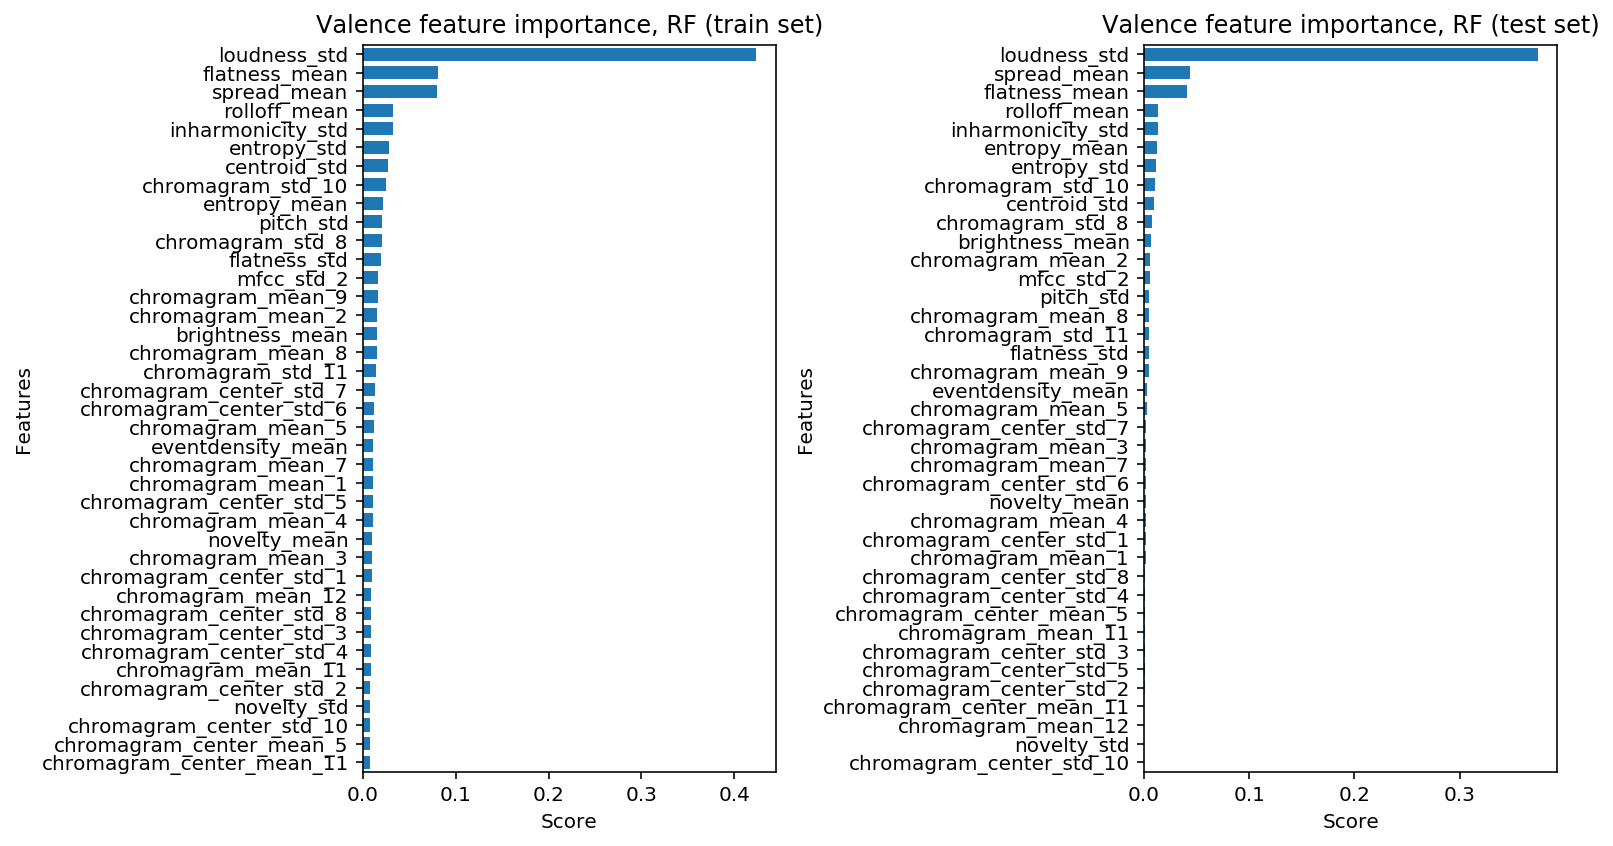

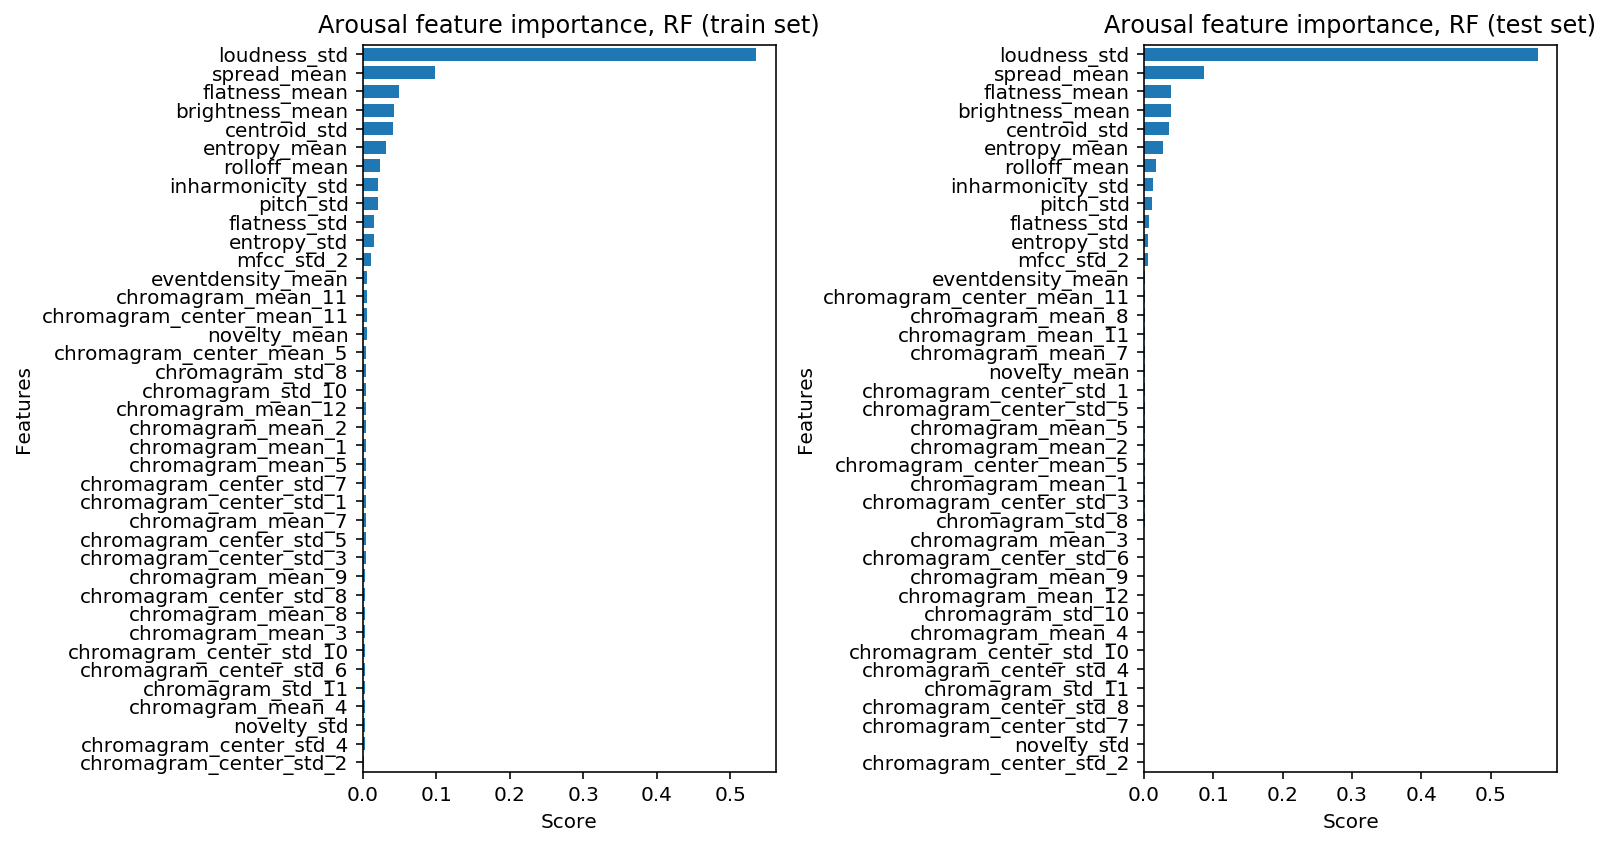

In [27]:
importance_sorted_idx_train_valence_RF = np.argsort(final_feature_importance_train_valence_RF)
indices_train_valence_RF = np.arange(0, len(final_feature_importance_train_valence_RF)) + 0.5

importance_sorted_idx_test_valence_RF = np.argsort(final_feature_importance_test_valence_RF)
indices_test_valence_RF = np.arange(0, len(final_feature_importance_test_valence_RF)) + 0.5


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(11, 6))
ax1.barh(indices_train_valence_RF,
         final_feature_importance_train_valence_RF[importance_sorted_idx_train_valence_RF], height=0.7)

ax1.set_yticklabels(XData.columns[importance_sorted_idx_train_valence_RF])
ax1.set_yticks(indices_train_valence_RF)
ax1.set_ylim((0, len(final_feature_importance_train_valence_RF)))
ax1.set_ylabel("Features")
ax1.set_xlabel("Score")
ax1.set_title("Valence feature importance, RF (train set)")

ax2.barh(indices_test_valence_RF,
         final_feature_importance_test_valence_RF[importance_sorted_idx_test_valence_RF], height=0.7)
ax2.set_yticklabels(XData.columns[importance_sorted_idx_test_valence_RF])
ax2.set_yticks(indices_test_valence_RF)
ax2.set_ylim((0, len(final_feature_importance_test_valence_RF)))
ax2.set_ylabel("Features")
ax2.set_xlabel("Score")
ax2.set_title("Valence feature importance, RF (test set)")
fig.tight_layout()
plt.show()

importance_sorted_idx_train_arousal_RF = np.argsort(final_feature_importance_train_arousal_RF)
indices_train_arousal_RF = np.arange(0, len(final_feature_importance_train_arousal_RF)) + 0.5

importance_sorted_idx_test_arousal_RF = np.argsort(final_feature_importance_test_arousal_RF)
indices_test_arousal_RF = np.arange(0, len(final_feature_importance_test_arousal_RF)) + 0.5

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(11, 6))
ax1.barh(indices_train_arousal_RF,
         final_feature_importance_train_arousal_RF[importance_sorted_idx_train_arousal_RF], height=0.7)

ax1.set_yticklabels(XData.columns[importance_sorted_idx_train_arousal_RF])
ax1.set_yticks(indices_train_arousal_RF)
ax1.set_ylim((0, len(final_feature_importance_train_arousal_RF)))
ax1.set_ylabel("Features")
ax1.set_xlabel("Score")
ax1.set_title("Arousal feature importance, RF (train set)")

ax2.barh(indices_test_arousal_RF,
         final_feature_importance_test_arousal_RF[importance_sorted_idx_test_arousal_RF], height=0.7)
ax2.set_yticklabels(XData.columns[importance_sorted_idx_test_arousal_RF])
ax2.set_yticks(indices_test_arousal_RF)
ax2.set_ylim((0, len(final_feature_importance_test_arousal_RF)))
ax2.set_ylabel("Features")
ax2.set_xlabel("Score")
ax2.set_title("Arousal feature importance, RF (test set)")
fig.tight_layout()
plt.show()

The subsets of the most important features are created based on the results of the previous graphs:

In [28]:
XData_10_features_valence_RF = ['loudness_std','spread_mean','flatness_mean',
                        'rolloff_mean', 'inharmonicity_std', 'entropy_mean',
                        'entropy_std','chromagram_std_10','centroid_std','chromagram_std_8'
                        ]

XData_5_features_valence_RF = ['loudness_std','spread_mean','flatness_mean',
                        'rolloff_mean','inharmonicity_std']

XData_10_features_arousal_RF = ['loudness_std','spread_mean','flatness_mean',
                        'brightness_mean','centroid_std','entropy_mean',
                        'rolloff_mean', 'inharmonicity_std','pitch_std','flatness_std']

XData_5_features_arousal_RF = ['loudness_std','spread_mean','flatness_mean',
                        'brightness_mean','centroid_std']

### RF with the 10 most important features

In [29]:
#This time the same process will be executed but in the 10 most important features only

R2_valence_RF_10F = []
MSE_valence_RF_10F = []
R2_arousal_RF_10F = []
MSE_arousal_RF_10F = []

start = time.time()
iteration= 0
for train_index, test_index in Kfolds_cv2.split(XData):

    print("ITERATION: ",iteration)
    
    X_train_RF, X_test_RF = XData.iloc[train_index,:], XData.iloc[test_index,:]
    
    X_train_valence_RF, X_test_valence_RF = X_train_RF.loc[:,XData_10_features_valence_RF], X_test_RF.loc[:,XData_10_features_valence_RF]
    X_train_arousal_RF, X_test_arousal_RF = X_train_RF.loc[:,XData_10_features_arousal_RF], X_test_RF.loc[:,XData_10_features_arousal_RF]
    
    y_train_valence_RF, y_test_valence_RF = YvalenceRF.iloc[train_index,:],  YvalenceRF.iloc[test_index , :]
    y_train_arousal_RF, y_test_arousal_RF = YarousalRF.iloc[train_index,:],  YarousalRF.iloc[test_index, :]
    
    print("X train valence shape: " , X_train_valence_RF.shape)
    print("X test valence shape: " , X_test_valence_RF.shape)
    print("X train arousal shape: " , X_train_arousal_RF.shape)
    print("X test arousal shape: " , X_test_arousal_RF.shape)
    
    
    #VALENCE
    CV_RF_valence = GridSearchCV( estimator = RandomForestRegressor() , param_grid=param_grid_valence_RF, 
                                  cv= Kfolds_cv , n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_RF_valence.fit(X_train_valence_RF, y_train_valence_RF.iloc[:,1] )

    RF_final_valence = CV_RF_valence.best_estimator_

    RF_y_predicted_valence = RF_final_valence.predict(X_test_valence_RF)

    R2score = r2_score(y_test_valence_RF.iloc[:,1] , RF_y_predicted_valence)
    MSEscore = mean_squared_error( y_test_valence_RF.iloc[:,1] , RF_y_predicted_valence)
    
    MSE_valence_RF_10F.append(MSEscore)
    R2_valence_RF_10F.append(R2score)
    
    print('Best params: {} '.format( CV_RF_valence.best_params_))
    print("R2 score: " , R2score)

    #AROUSAL
    CV_RF_arousal = GridSearchCV( estimator = RandomForestRegressor() , param_grid=param_grid_arousal_RF,
                                  cv= Kfolds_cv ,  n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_RF_arousal.fit(X_train_arousal_RF, y_train_arousal_RF.iloc[:,1] )

    RF_final_arousal = CV_RF_arousal.best_estimator_

    RF_y_predicted_arousal = RF_final_arousal.predict(X_test_arousal_RF)

    R2score = r2_score(y_test_arousal_RF.iloc[:,1] , RF_y_predicted_arousal)
    MSEscore = mean_squared_error(y_test_arousal_RF.iloc[:,1] , RF_y_predicted_arousal)
    
    MSE_arousal_RF_10F.append(MSEscore)
    R2_arousal_RF_10F.append(R2score)
    
    print('Best params: {} '.format( CV_RF_arousal.best_params_))
    print("R2 score: " , R2score)
    iteration = iteration +1
    
print("Time (minutes):")
print((time.time()-start)/60)
print("\n")

ITERATION:  0
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 39.8min finished


Best params: {'bootstrap': True, 'max_depth': 110, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 300} 
R2 score:  0.6580420551785818
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.0min finished


Best params: {'bootstrap': True, 'max_depth': 70, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200} 
R2 score:  0.8981951240289674
ITERATION:  1
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 40.0min finished


Best params: {'bootstrap': True, 'max_depth': 110, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2000} 
R2 score:  0.6384487550841367
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.0min finished


Best params: {'bootstrap': True, 'max_depth': 70, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100} 
R2 score:  0.8764056757081767
ITERATION:  2
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 39.9min finished


Best params: {'bootstrap': True, 'max_depth': 120, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300} 
R2 score:  0.6436433788613725
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.0min finished


Best params: {'bootstrap': True, 'max_depth': 70, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 300} 
R2 score:  0.9080740238121974
ITERATION:  3
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 40.0min finished


Best params: {'bootstrap': True, 'max_depth': 110, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 1500} 
R2 score:  0.6349643899586073
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.0min finished


Best params: {'bootstrap': True, 'max_depth': 60, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 300} 
R2 score:  0.8844999471377044
ITERATION:  4
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 40.0min finished


Best params: {'bootstrap': True, 'max_depth': 120, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 300} 
R2 score:  0.6948517660049813
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.0min finished


Best params: {'bootstrap': True, 'max_depth': 70, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100} 
R2 score:  0.9058309455313195
ITERATION:  5
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 40.0min finished


Best params: {'bootstrap': True, 'max_depth': 120, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 2000} 
R2 score:  0.6613001617728682
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.0min finished


Best params: {'bootstrap': True, 'max_depth': 50, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300} 
R2 score:  0.8834571027603003
ITERATION:  6
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 40.0min finished


Best params: {'bootstrap': True, 'max_depth': 120, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 300} 
R2 score:  0.6215767982319669
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.0min finished


Best params: {'bootstrap': True, 'max_depth': 50, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300} 
R2 score:  0.8928813907454107
ITERATION:  7
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.3min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 41.8min finished


Best params: {'bootstrap': True, 'max_depth': 100, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 300} 
R2 score:  0.7133620191878678
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  9.2min finished


Best params: {'bootstrap': True, 'max_depth': 60, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300} 
R2 score:  0.8811606915515738
ITERATION:  8
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 40.5min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 52.0min finished


Best params: {'bootstrap': True, 'max_depth': 120, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1500} 
R2 score:  0.6719931070616711
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.8min finished


Best params: {'bootstrap': True, 'max_depth': 50, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 300} 
R2 score:  0.8628244949203436
ITERATION:  9
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 45.2min finished


Best params: {'bootstrap': True, 'max_depth': 100, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 2000} 
R2 score:  0.6838515554168942
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  7.7min finished


Best params: {'bootstrap': True, 'max_depth': 60, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 200} 
R2 score:  0.8935925098833329
Time (minutes):
485.1054803490639




In [30]:
print("Valence R2 RF: {0:.3f}".format(np.mean(R2_valence_RF_10F)) + " std {0:.3f}".format(np.std(R2_valence_RF_10F)))
print("Arousal R2 RF: {0:.3f}".format(np.mean(R2_arousal_RF_10F)) + " std {0:.3f}".format(np.std(R2_arousal_RF_10F)))

print("Valence MSE RF: {0:.3f}".format(np.mean(MSE_valence_RF_10F)) + " std {0:.3f}".format(np.std(MSE_valence_RF_10F)))
print("Arousal MSE RF: {0:.3f}".format(np.mean(MSE_arousal_RF_10F)) + " std {0:.3f}".format(np.std(MSE_arousal_RF_10F)))

Valence R2 RF: 0.662 std 0.028
Arousal R2 RF: 0.889 std 0.013
Valence MSE RF: 0.110 std 0.007
Arousal MSE RF: 0.036 std 0.004


### RF with the 5 most important features

In [31]:
#This time the same process will be executed but in the 5 most important features only

#Because the number of features used now is 5, the max_features values of the param grid is changed accordingly
param_grid_valence_RF_5F = {
    'bootstrap': [True],
    'max_depth': [ 100, 110,120],
    'max_features': [  3, 4, 5],
    'min_samples_leaf': [1,2, 3],
    'min_samples_split': [3,4,5],
    'n_estimators': [1500, 2000,300]
}
param_grid_arousal_RF_5F = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70],
    'max_features': [3, 4, 5],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [5,6,7],
    'n_estimators': [ 100,200, 300]
}

R2_valence_RF_5F = []
MSE_valence_RF_5F = []
R2_arousal_RF_5F = []
MSE_arousal_RF_5F = []

start = time.time()
iteration= 0
for train_index, test_index in Kfolds_cv2.split(XData):

    print("ITERATION: ",iteration)
    
    X_train_RF, X_test_RF = XData.iloc[train_index,:], XData.iloc[test_index,:]
    
    X_train_valence_RF, X_test_valence_RF = X_train_RF.loc[:,XData_5_features_valence_RF], X_test_RF.loc[:,XData_5_features_valence_RF]
    X_train_arousal_RF, X_test_arousal_RF = X_train_RF.loc[:,XData_5_features_arousal_RF], X_test_RF.loc[:,XData_5_features_arousal_RF]
    
    y_train_valence_RF, y_test_valence_RF = YvalenceRF.iloc[train_index,:],  YvalenceRF.iloc[test_index , :]
    y_train_arousal_RF, y_test_arousal_RF = YarousalRF.iloc[train_index,:],  YarousalRF.iloc[test_index, :]
    
    print("X train valence shape: " , X_train_valence_RF.shape)
    print("X test valence shape: " , X_test_valence_RF.shape)
    print("X train arousal shape: " , X_train_arousal_RF.shape)
    print("X test arousal shape: " , X_test_arousal_RF.shape)
    
    
    #VALENCE
    CV_RF_valence = GridSearchCV( estimator = RandomForestRegressor() , param_grid=param_grid_valence_RF_5F, 
                                  cv= Kfolds_cv , n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_RF_valence.fit(X_train_valence_RF, y_train_valence_RF.iloc[:,1] )

    RF_final_valence = CV_RF_valence.best_estimator_

    RF_y_predicted_valence = RF_final_valence.predict(X_test_valence_RF)

    R2score = r2_score(y_test_valence_RF.iloc[:,1] , RF_y_predicted_valence)
    MSEscore = mean_squared_error( y_test_valence_RF.iloc[:,1] , RF_y_predicted_valence)
    
    MSE_valence_RF_5F.append(MSEscore)
    R2_valence_RF_5F.append(R2score)
    
    print('Best params: {} '.format( CV_RF_valence.best_params_))
    print("R2 score: " , R2score)

    #AROUSAL
    CV_RF_arousal = GridSearchCV( estimator = RandomForestRegressor() , param_grid=param_grid_arousal_RF_5F,
                                  cv= Kfolds_cv ,  n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_RF_arousal.fit(X_train_arousal_RF, y_train_arousal_RF.iloc[:,1] )

    RF_final_arousal = CV_RF_arousal.best_estimator_

    RF_y_predicted_arousal = RF_final_arousal.predict(X_test_arousal_RF)

    R2score = r2_score(y_test_arousal_RF.iloc[:,1] , RF_y_predicted_arousal)
    MSEscore = mean_squared_error(y_test_arousal_RF.iloc[:,1] , RF_y_predicted_arousal)
    
    MSE_arousal_RF_5F.append(MSEscore)
    R2_arousal_RF_5F.append(R2score)
    
    print('Best params: {} '.format( CV_RF_arousal.best_params_))
    print("R2 score: " , R2score)
    iteration = iteration +1
    
print("Time (minutes):")
print((time.time()-start)/60)
print("\n")

ITERATION:  0
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 37.4min finished


Best params: {'bootstrap': True, 'max_depth': 120, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 2000} 
R2 score:  0.6128247271114662
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  5.1min finished


Best params: {'bootstrap': True, 'max_depth': 70, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 100} 
R2 score:  0.8719818242634416
ITERATION:  1
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 33.9min finished


Best params: {'bootstrap': True, 'max_depth': 120, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1500} 
R2 score:  0.6128547401510922
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  5.6min finished


Best params: {'bootstrap': True, 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100} 
R2 score:  0.8553651081446074
ITERATION:  2
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 37.1min finished


Best params: {'bootstrap': True, 'max_depth': 120, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 2000} 
R2 score:  0.5853157295095484
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  5.3min finished


Best params: {'bootstrap': True, 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 200} 
R2 score:  0.8869542763546037
ITERATION:  3
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 36.2min finished


Best params: {'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 2000} 
R2 score:  0.6087376396614608
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  5.3min finished


Best params: {'bootstrap': True, 'max_depth': 60, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200} 
R2 score:  0.8717346049610804
ITERATION:  4
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 37.3min finished


Best params: {'bootstrap': True, 'max_depth': 120, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 300} 
R2 score:  0.6597540252554458
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  5.3min finished


Best params: {'bootstrap': True, 'max_depth': 50, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300} 
R2 score:  0.88060960289471
ITERATION:  5
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 34.4min finished


Best params: {'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 2000} 
R2 score:  0.629491349392395
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  5.2min finished


Best params: {'bootstrap': True, 'max_depth': 60, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100} 
R2 score:  0.8643973848305226
ITERATION:  6
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 34.1min finished


Best params: {'bootstrap': True, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1500} 
R2 score:  0.5692042406287916
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  5.2min finished


Best params: {'bootstrap': True, 'max_depth': 70, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200} 
R2 score:  0.8765565644576359
ITERATION:  7
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 34.0min finished


Best params: {'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 300} 
R2 score:  0.6670549575683455
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  5.2min finished


Best params: {'bootstrap': True, 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 300} 
R2 score:  0.8500687635803665
ITERATION:  8
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 33.6min finished


Best params: {'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 2000} 
R2 score:  0.6489496680423026
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  5.0min finished


Best params: {'bootstrap': True, 'max_depth': 70, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 300} 
R2 score:  0.840706048424048
ITERATION:  9
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 33.4min finished


Best params: {'bootstrap': True, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 300} 
R2 score:  0.6242509216833843
Fitting 10 folds for each of 243 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  5.0min finished


Best params: {'bootstrap': True, 'max_depth': 60, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 200} 
R2 score:  0.8753616431133452
Time (minutes):
404.0461224357287




In [32]:
print("Valence R2 RF: {0:.3f}".format(np.mean(R2_valence_RF_5F)) + " std {0:.3f}".format(np.std(R2_valence_RF_5F)))
print("Arousal R2 RF: {0:.3f}".format(np.mean(R2_arousal_RF_5F)) + " std {0:.3f}".format(np.std(R2_arousal_RF_5F)))

print("Valence MSE RF: {0:.3f}".format(np.mean(MSE_valence_RF_5F)) + " std {0:.3f}".format(np.std(MSE_valence_RF_5F)))
print("Arousal MSE RF: {0:.3f}".format(np.mean(MSE_arousal_RF_5F)) + " std {0:.3f}".format(np.std(MSE_arousal_RF_5F)))

Valence R2 RF: 0.622 std 0.030
Arousal R2 RF: 0.867 std 0.014
Valence MSE RF: 0.123 std 0.007
Arousal MSE RF: 0.043 std 0.004


## GPR:




In [23]:
YvalenceGP = pd.DataFrame(Yvalence) 
YarousalGP = pd.DataFrame(Yarousal) 

### GPR with the 39 selected features, comparing different kernels

In [9]:
 
R2_scores_RBF_valence_AllF = []
R2_scores_LIN_valence_AllF = []
R2_scores_RQ_valence_AllF = []
R2_scores_MAT3_valence_AllF = []
R2_scores_LIN_RQ_valence_AllF = []
R2_scores_MAT3_RQ_valence_AllF = []
R2_scores_RBF_RQ_valence_AllF = []
MSE_scores_RBF_valence_AllF = []
MSE_scores_LIN_valence_AllF = []
MSE_scores_RQ_valence_AllF = []
MSE_scores_MAT3_valence_AllF = []
MSE_scores_LIN_RQ_valence_AllF = []
MSE_scores_MAT3_RQ_valence_AllF = []
MSE_scores_RBF_RQ_valence_AllF = []

R2_scores_RBF_arousal_AllF = []
R2_scores_LIN_arousal_AllF = []
R2_scores_RQ_arousal_AllF = []
R2_scores_MAT3_arousal_AllF = []
R2_scores_LIN_RQ_arousal_AllF = []
R2_scores_MAT3_RQ_arousal_AllF = []
R2_scores_RBF_RQ_arousal_AllF = []
MSE_scores_RBF_arousal_AllF = []
MSE_scores_LIN_arousal_AllF = []
MSE_scores_RQ_arousal_AllF = []
MSE_scores_MAT3_arousal_AllF = []
MSE_scores_LIN_RQ_arousal_AllF = []
MSE_scores_MAT3_RQ_arousal_AllF = []
MSE_scores_RBF_RQ_arousal_AllF = []


start = time.time()
KFolds_shuffleSplit =  ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
iteration = 0 

for train_index, test_index in KFolds_shuffleSplit.split(XData):

    print("ITERATION: ",iteration)

    X_train_GP, X_test_GP = XData.iloc[ train_index , :], XData.iloc[ test_index , : ]
    y_train_valence_GP, y_test_valence_GP = YvalenceGP.iloc[train_index,:],  YvalenceGP.iloc[test_index , :]
    y_train_arousal_GP, y_test_arousal_GP = YarousalGP.iloc[train_index,:],  YarousalGP.iloc[test_index, :]


    kernel_valence_RBF = GPy.kern.RBF( input_dim=39 , ARD = True )
    kernel_valence_LIN = GPy.kern.Linear( input_dim=39 , ARD = True )
    kernel_valence_RQ = GPy.kern.RatQuad( input_dim=39 , ARD = True )
    kernel_valence_MAT3 = GPy.kern.Matern32( input_dim=39 , ARD = True )
    kernel_valence_LIN_RQ = GPy.kern.Linear( input_dim=39 , ARD = True ) + GPy.kern.RatQuad( input_dim=39 , ARD = True )
    kernel_Valence_MAT3_RQ = GPy.kern.Matern32( input_dim=39 , ARD = True ) + GPy.kern.RatQuad( input_dim=39 , ARD = True )

    GP_model_valence_RBF = GPy.models.GPRegression(X_train_GP , y_train_valence_GP.iloc[:,1].values.reshape([-1,1]),kernel_valence_RBF)
    GP_model_valence_LIN = GPy.models.GPRegression(X_train_GP , y_train_valence_GP.iloc[:,1].values.reshape([-1,1]),kernel_valence_LIN)
    GP_model_valence_RQ = GPy.models.GPRegression(X_train_GP , y_train_valence_GP.iloc[:,1].values.reshape([-1,1]),kernel_valence_RQ)
    GP_model_valence_MAT3 = GPy.models.GPRegression(X_train_GP , y_train_valence_GP.iloc[:,1].values.reshape([-1,1]),kernel_valence_MAT3)
    GP_model_valence_LIN_RQ = GPy.models.GPRegression(X_train_GP , y_train_valence_GP.iloc[:,1].values.reshape([-1,1]),kernel_valence_LIN_RQ)
    GP_model_valence_MAT3_RQ = GPy.models.GPRegression(X_train_GP , y_train_valence_GP.iloc[:,1].values.reshape([-1,1]),kernel_Valence_MAT3_RQ)
    
    GP_model_valence_RBF.optimize(messages=False, max_iters=2000)
    GP_model_valence_LIN.optimize(messages=False, max_iters=2000)
    GP_model_valence_RQ.optimize(messages=False, max_iters=2000)
    GP_model_valence_MAT3.optimize(messages=False, max_iters=2000)
    GP_model_valence_LIN_RQ.optimize(messages=False, max_iters=2000)
    GP_model_valence_MAT3_RQ.optimize(messages=False, max_iters=2000)
    
    
    kernel_arousal_RBF = GPy.kern.RBF( input_dim=39 , ARD = True )
    kernel_arousal_LIN = GPy.kern.Linear( input_dim=39 , ARD = True )
    kernel_arousal_RQ = GPy.kern.RatQuad( input_dim=39 , ARD = True )
    kernel_arousal_MAT3 = GPy.kern.Matern32( input_dim=39 , ARD = True )
    kernel_arousal_LIN_RQ = GPy.kern.Linear( input_dim=39 , ARD = True ) + GPy.kern.RatQuad( input_dim=39 , ARD = True )
    kernel_arousal_MAT3_RQ = GPy.kern.Matern32( input_dim=39 , ARD = True ) + GPy.kern.RatQuad( input_dim=39 , ARD = True )


    GP_model_arousal_RBF = GPy.models.GPRegression(X_train_GP , y_train_arousal_GP.iloc[:,1].values.reshape([-1,1]),kernel_arousal_RBF)
    GP_model_arousal_LIN = GPy.models.GPRegression(X_train_GP , y_train_arousal_GP.iloc[:,1].values.reshape([-1,1]),kernel_arousal_LIN)
    GP_model_arousal_RQ = GPy.models.GPRegression(X_train_GP , y_train_arousal_GP.iloc[:,1].values.reshape([-1,1]),kernel_arousal_RQ)
    GP_model_arousal_MAT3 = GPy.models.GPRegression(X_train_GP, y_train_arousal_GP.iloc[:,1].values.reshape([-1,1]),kernel_arousal_MAT3)
    GP_model_arousal_LIN_RQ = GPy.models.GPRegression(X_train_GP, y_train_arousal_GP.iloc[:,1].values.reshape([-1,1]),kernel_arousal_LIN_RQ)
    GP_model_arousal_MAT3_RQ = GPy.models.GPRegression(X_train_GP, y_train_arousal_GP.iloc[:,1].values.reshape([-1,1]),kernel_arousal_MAT3_RQ)

    GP_model_arousal_RBF.optimize(messages=False , max_iters=2000)
    GP_model_arousal_LIN.optimize(messages=False, max_iters=2000)
    GP_model_arousal_RQ.optimize(messages=False, max_iters=2000)
    GP_model_arousal_MAT3.optimize(messages=False, max_iters=2000)
    GP_model_arousal_LIN_RQ.optimize(messages=False, max_iters=2000)
    GP_model_arousal_MAT3_RQ.optimize(messages=False, max_iters=2000)

    meanYtest_valence,_ = GP_model_valence_RBF.predict(X_test_GP.to_numpy())
    R2_scores_RBF_valence_AllF.append(r2_score(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))
    MSE_scores_RBF_valence_AllF.append(mean_squared_error(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))
    
    meanYtest_valence,_ = GP_model_valence_LIN.predict(X_test_GP.to_numpy())
    R2_scores_LIN_valence_AllF.append(r2_score(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))
    MSE_scores_LIN_valence_AllF.append(mean_squared_error(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))

    meanYtest_valence,_ = GP_model_valence_RQ.predict(X_test_GP.to_numpy())
    R2_scores_RQ_valence_AllF.append(r2_score(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))
    MSE_scores_RQ_valence_AllF.append(mean_squared_error(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))

    meanYtest_valence,_ = GP_model_valence_MAT3.predict(X_test_GP.to_numpy())
    R2_scores_MAT3_valence_AllF.append(r2_score(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))
    MSE_scores_MAT3_valence_AllF.append(mean_squared_error(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))

    meanYtest_valence,_ = GP_model_valence_LIN_RQ.predict(X_test_GP.to_numpy())
    R2_scores_LIN_RQ_valence_AllF.append(r2_score(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))
    MSE_scores_LIN_RQ_valence_AllF.append(mean_squared_error(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))

    meanYtest_valence,_ = GP_model_valence_MAT3_RQ.predict(X_test_GP.to_numpy())
    R2_scores_MAT3_RQ_valence_AllF.append(r2_score(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))
    MSE_scores_MAT3_RQ_valence_AllF.append(mean_squared_error(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))

    meanYtest_arousal,_ = GP_model_arousal_RBF.predict(X_test_GP.to_numpy())
    R2_scores_RBF_arousal_AllF.append(r2_score(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))
    MSE_scores_RBF_arousal_AllF.append(mean_squared_error(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))

    meanYtest_arousal,_ = GP_model_arousal_LIN.predict(X_test_GP.to_numpy())
    R2_scores_LIN_arousal_AllF.append(r2_score(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))
    MSE_scores_LIN_arousal_AllF.append(mean_squared_error(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))

    meanYtest_arousal,_ = GP_model_arousal_RQ.predict(X_test_GP.to_numpy())
    R2_scores_RQ_arousal_AllF.append(r2_score(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))
    MSE_scores_RQ_arousal_AllF.append(mean_squared_error(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))

    meanYtest_arousal,_ = GP_model_arousal_MAT3.predict(X_test_GP.to_numpy())
    R2_scores_MAT3_arousal_AllF.append(r2_score(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))
    MSE_scores_MAT3_arousal_AllF.append(mean_squared_error(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))

    meanYtest_arousal,_ = GP_model_arousal_LIN_RQ.predict(X_test_GP.to_numpy())
    R2_scores_LIN_RQ_arousal_AllF.append(r2_score(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))
    MSE_scores_LIN_RQ_arousal_AllF.append(mean_squared_error(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))

    meanYtest_arousal,_ = GP_model_arousal_MAT3_RQ.predict(X_test_GP.to_numpy())
    R2_scores_MAT3_RQ_arousal_AllF.append(r2_score(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))
    MSE_scores_MAT3_RQ_arousal_AllF.append(mean_squared_error(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))

    iteration = iteration +1

print("Time (minutes):")
print((time.time()-start)/60)
print("\n")




ITERATION:  0
ITERATION:  1
ITERATION:  2
ITERATION:  3


 C:\Users\Gon\anaconda3\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\Gon\anaconda3\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


ITERATION:  4


 C:\Users\Gon\anaconda3\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\Gon\anaconda3\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


ITERATION:  5
ITERATION:  6
ITERATION:  7
ITERATION:  8
ITERATION:  9


 C:\Users\Gon\anaconda3\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\Gon\anaconda3\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


Time (minutes):
722.0733322898546




In [10]:

print("Valence RBF R2: {0:.3f}".format(np.mean(R2_scores_RBF_valence_AllF)) + " std {0:.3f}".format(np.std(R2_scores_RBF_valence_AllF)))
print("Valence RBF MSE: {0:.3f}".format(np.mean(MSE_scores_RBF_valence_AllF)) + " std {0:.3f}".format(np.std(MSE_scores_RBF_valence_AllF)))

print("Valence LIN R2: {0:.3f}".format(np.mean(R2_scores_LIN_valence_AllF)) + " std {0:.3f}".format(np.std(R2_scores_LIN_valence_AllF)))
print("Valence LIN MSE: {0:.3f}".format(np.mean(MSE_scores_LIN_valence_AllF)) + " std {0:.3f}".format(np.std(MSE_scores_LIN_valence_AllF)))

print("Valence RQ R2: {0:.3f}".format(np.mean(R2_scores_RQ_valence_AllF)) + " std {0:.3f}".format(np.std(R2_scores_RQ_valence_AllF)))
print("Valence RQ MSE: {0:.3f}".format(np.mean(MSE_scores_RQ_valence_AllF)) + " std {0:.3f}".format(np.std(MSE_scores_RQ_valence_AllF)))

print("Valence MAT3 R2: {0:.3f}".format(np.mean(R2_scores_MAT3_valence_AllF)) + " std {0:.3f}".format(np.std(R2_scores_MAT3_valence_AllF)))
print("Valence MAT3 MSE: {0:.3f}".format(np.mean(MSE_scores_MAT3_valence_AllF)) + " std {0:.3f}".format(np.std(MSE_scores_MAT3_valence_AllF)))

print("Valence LIN + RQ R2: {0:.3f}".format(np.mean(R2_scores_LIN_RQ_valence_AllF)) + " std {0:.3f}".format(np.std(R2_scores_LIN_RQ_valence_AllF)))
print("Valence LIN + RQ MSE: {0:.3f}".format(np.mean(MSE_scores_LIN_RQ_valence_AllF)) + " std {0:.3f}".format(np.std(MSE_scores_LIN_RQ_valence_AllF)))

print("Valence MAT3 + RQ R2: {0:.3f}".format(np.mean(R2_scores_MAT3_RQ_valence_AllF)) + " std {0:.3f}".format(np.std(R2_scores_MAT3_RQ_valence_AllF)))
print("Valence MAT3 + RQ MSE: {0:.3f}".format(np.mean(MSE_scores_MAT3_RQ_valence_AllF)) + " std {0:.3f}".format(np.std(MSE_scores_MAT3_RQ_valence_AllF)))


print("Arousal RBF R2: {0:.3f}".format(np.mean(R2_scores_RBF_arousal_AllF)) + " std {0:.3f}".format(np.std(R2_scores_RBF_arousal_AllF)))
print("Arousal RBF MSE: {0:.3f}".format(np.mean(MSE_scores_RBF_arousal_AllF)) + " std {0:.3f}".format(np.std(MSE_scores_RBF_arousal_AllF)))

print("Arousal LIN R2 : {0:.3f}".format(np.mean(R2_scores_LIN_arousal_AllF)) + " std {0:.3f}".format(np.std(R2_scores_LIN_arousal_AllF)))
print("Arousal LIN MSE: {0:.3f}".format(np.mean(MSE_scores_LIN_arousal_AllF)) + " std {0:.3f}".format(np.std(MSE_scores_LIN_arousal_AllF)))

print("Arousal RQ R2: {0:.3f}".format(np.mean(R2_scores_RQ_arousal_AllF)) + " std {0:.3f}".format(np.std(R2_scores_RQ_arousal_AllF)))
print("Arousal RQ MSE: {0:.3f}".format(np.mean(MSE_scores_RQ_arousal_AllF)) + " std {0:.3f}".format(np.std(MSE_scores_RQ_arousal_AllF)))

print("Arousal MAT3 R2: {0:.3f}".format(np.mean(R2_scores_MAT3_arousal_AllF)) + " std {0:.3f}".format(np.std(R2_scores_MAT3_arousal_AllF)))
print("Arousal MAT3 MSE: {0:.3f}".format(np.mean(MSE_scores_MAT3_arousal_AllF)) + " std {0:.3f}".format(np.std(MSE_scores_MAT3_arousal_AllF)))

print("Arousal LIN + RQ R2: {0:.3f}".format(np.mean(R2_scores_LIN_RQ_arousal_AllF)) + " std {0:.3f}".format(np.std(R2_scores_LIN_RQ_arousal_AllF)))
print("Arousal LIN + RQ MSE: {0:.3f}".format(np.mean(MSE_scores_LIN_RQ_arousal_AllF)) + " std {0:.3f}".format(np.std(MSE_scores_LIN_RQ_arousal_AllF)))

print("Arousal MAT3 + RQ R2: {0:.3f}".format(np.mean(R2_scores_MAT3_RQ_arousal_AllF)) + " std {0:.3f}".format(np.std(R2_scores_MAT3_RQ_arousal_AllF)))
print("Arousal MAT3 + RQ MSE: {0:.3f}".format(np.mean(MSE_scores_MAT3_RQ_arousal_AllF)) + " std {0:.3f}".format(np.std(MSE_scores_MAT3_RQ_arousal_AllF)))





Valence RBF R2: 0.652 std 0.032
Valence RBF MSE: 0.113 std 0.008
Valence LIN R2: 0.582 std 0.034
Valence LIN MSE: 0.136 std 0.010
Valence RQ R2: 0.681 std 0.034
Valence RQ MSE: 0.103 std 0.009
Valence MAT3 R2: 0.676 std 0.032
Valence MAT3 MSE: 0.105 std 0.009
Valence LIN + RQ R2: 0.670 std 0.032
Valence LIN + RQ MSE: 0.107 std 0.008
Valence MAT3 + RQ R2: 0.676 std 0.028
Valence MAT3 + RQ MSE: 0.105 std 0.007
Arousal RBF R2: 0.907 std 0.008
Arousal RBF MSE: 0.030 std 0.003
Arousal LIN R2 : 0.840 std 0.014
Arousal LIN MSE: 0.052 std 0.005
Arousal RQ R2: 0.907 std 0.008
Arousal RQ MSE: 0.030 std 0.003
Arousal MAT3 R2: 0.907 std 0.009
Arousal MAT3 MSE: 0.030 std 0.003
Arousal LIN + RQ R2: 0.903 std 0.008
Arousal LIN + RQ MSE: 0.031 std 0.003
Arousal MAT3 + RQ R2: 0.906 std 0.009
Arousal MAT3 + RQ MSE: 0.030 std 0.003


Compute the average lengthscale values of the RQ kernel (best kernel) for all the partitions in the cross-validation:

In [47]:
lengthscale_values_valence = []
lengthscale_values_arousal = []

R2_valence_GP_AllF = [] 
MSE_valence_GP_AllF = []

R2_arousal_GP_AllF = []
MSE_arousal_GP_AllF = []

YvalenceGP = pd.DataFrame(Yvalence) 
YarousalGP = pd.DataFrame(Yarousal) 

start = time.time()

KFolds_shuffleSplit =  ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
iteration = 0 

for train_index, test_index in KFolds_shuffleSplit.split(XData):

    print("ITERATION: ",iteration)

    X_train_GP, X_test_GP = XData.iloc[ train_index , :], XData.iloc[ test_index , : ]
    y_train_valence_GP, y_test_valence_GP = YvalenceGP.iloc[train_index,:],  YvalenceGP.iloc[test_index, :]
    y_train_arousal_GP, y_test_arousal_GP = YarousalGP.iloc[train_index,:],  YarousalGP.iloc[test_index, :]

    print("X train  shape: " , X_train_GP.shape)
    print("X test  shape: " , X_test_GP.shape)
   
    
    kernel_valence_RQ = GPy.kern.RatQuad( input_dim=39 , ARD = True )
    GP_model_valence_RQ = GPy.models.GPRegression(X_train_GP , y_train_valence_GP.iloc[:,1].values.reshape([-1,1]), kernel_valence_RQ)
    GP_model_valence_RQ.optimize(messages=False, max_iters=2000)
    
    meanYtest_valence,_ = GP_model_valence_RQ.predict(X_test_GP.to_numpy())
    R2_valence_GP_AllF.append(r2_score(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))
    MSE_valence_GP_AllF.append(mean_squared_error(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))

    lengthscale_values_valence.append(GP_model_valence_RQ.RatQuad.lengthscale.values)
    
    kernel_arousal_RQ = GPy.kern.RatQuad( input_dim=39 , ARD = True )
    GP_model_arousal_RQ = GPy.models.GPRegression(X_train_GP , y_train_arousal_GP.iloc[:,1].values.reshape([-1,1]),kernel_arousal_RQ)
    GP_model_arousal_RQ.optimize(messages=False, max_iters=2000)
    
    meanYtest_arousal,_ = GP_model_arousal_RQ.predict(X_test_GP.to_numpy())
    R2_arousal_GP_AllF.append(r2_score(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))
    MSE_arousal_GP_AllF.append(mean_squared_error(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))

    lengthscale_values_arousal.append(GP_model_arousal_RQ.RatQuad.lengthscale.values)

    iteration = iteration +1

print("Time (minutes):")
print((time.time()-start)/60)
print("\n")

lengthscale_values_valence = np.array(compute_feature_importance_of_folds(np.array(lengthscale_values_valence)))
lengthscale_values_arousal = np.array(compute_feature_importance_of_folds(np.array(lengthscale_values_arousal)))

ITERATION:  0
X train  shape:  (970, 39)
X test  shape:  (243, 39)
ITERATION:  1
X train  shape:  (970, 39)
X test  shape:  (243, 39)
ITERATION:  2
X train  shape:  (970, 39)
X test  shape:  (243, 39)
ITERATION:  3
X train  shape:  (970, 39)
X test  shape:  (243, 39)
ITERATION:  4
X train  shape:  (970, 39)
X test  shape:  (243, 39)
ITERATION:  5
X train  shape:  (970, 39)
X test  shape:  (243, 39)
ITERATION:  6
X train  shape:  (970, 39)
X test  shape:  (243, 39)
ITERATION:  7
X train  shape:  (970, 39)
X test  shape:  (243, 39)
ITERATION:  8
X train  shape:  (970, 39)
X test  shape:  (243, 39)
ITERATION:  9
X train  shape:  (970, 39)
X test  shape:  (243, 39)
Time (minutes):
92.21404203176499




In [51]:
print("Valence R2 RF: {0:.3f}".format(np.mean(R2_valence_GP_AllF)) + " std {0:.3f}".format(np.std(R2_valence_GP_AllF)))
print("Arousal R2 RF: {0:.3f}".format(np.mean(R2_arousal_GP_AllF)) + " std {0:.3f}".format(np.std(R2_arousal_GP_AllF)))

print("Valence MSE RF: {0:.3f}".format(np.mean(MSE_valence_GP_AllF)) + " std {0:.3f}".format(np.std(MSE_valence_GP_AllF)))
print("Arousal MSE RF: {0:.3f}".format(np.mean(MSE_arousal_GP_AllF)) + " std {0:.3f}".format(np.std(MSE_arousal_GP_AllF)))


Valence R2 RF: 0.681 std 0.034
Arousal R2 RF: 0.907 std 0.008
Valence MSE RF: 0.103 std 0.009
Arousal MSE RF: 0.030 std 0.003


IndexError: tuple index out of range

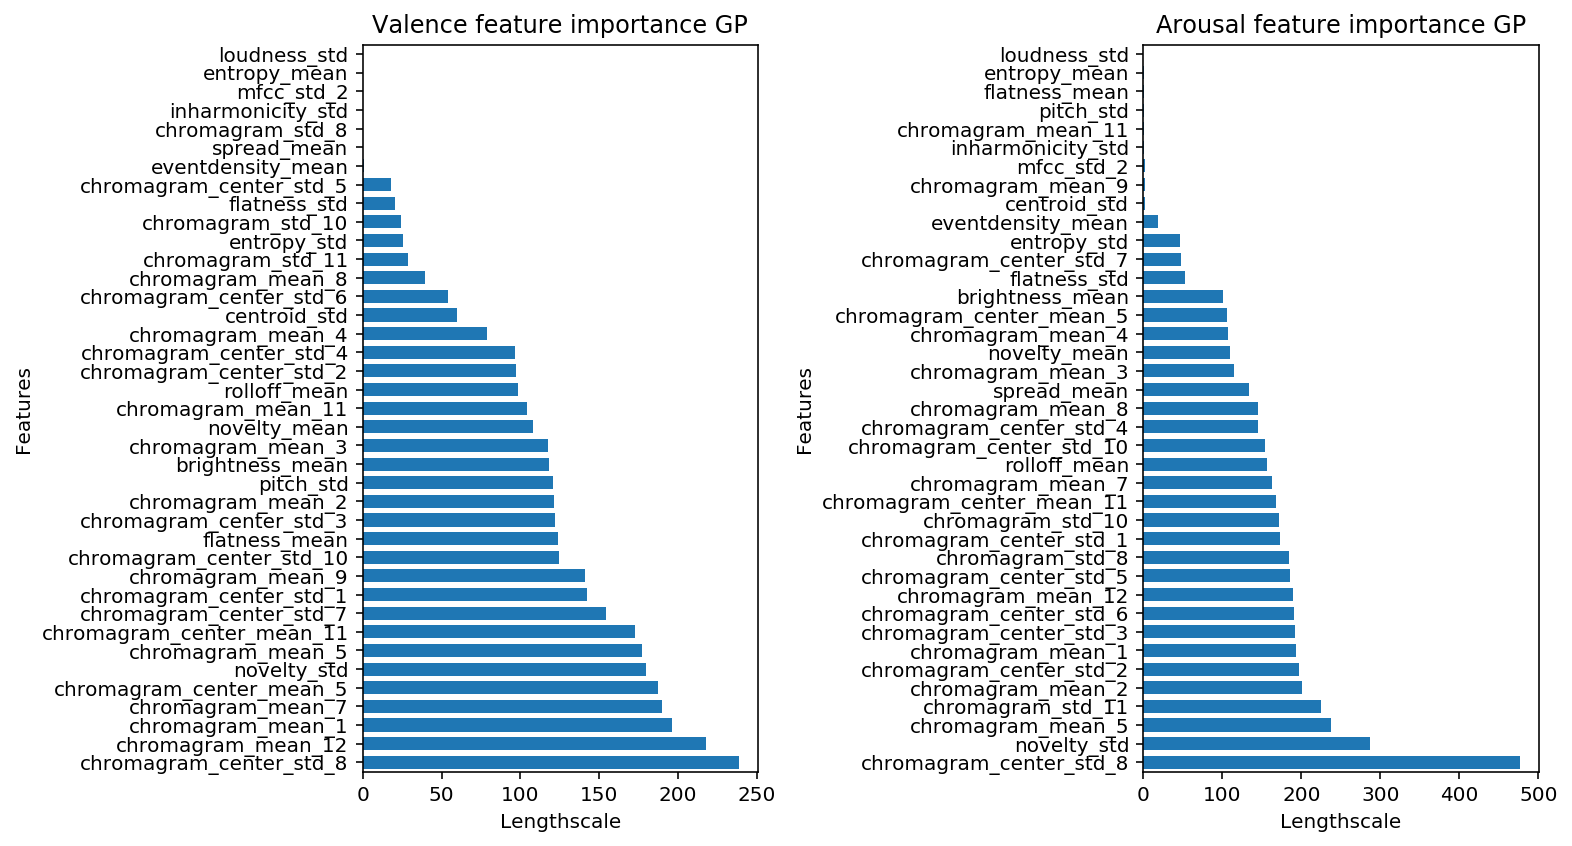

In [54]:

importance_sorted_idx_valence_GP = np.argsort(lengthscale_values_valence)[::-1]
indices_valence_GP = np.arange(0, len(lengthscale_values_valence)) + 0.5

importance_sorted_idx_arousal_GP = np.argsort(lengthscale_values_arousal)[::-1]
indices_arousal_GP = np.arange(0, len(lengthscale_values_arousal)) + 0.5


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(11, 6))
ax1.barh(indices_valence_GP,
         lengthscale_values_valence[importance_sorted_idx_valence_GP], height=0.7)

ax1.set_yticklabels(XData.columns[importance_sorted_idx_valence_GP])
ax1.set_yticks(indices_valence_GP)
ax1.set_ylim((0, len(lengthscale_values_valence)))
ax1.set_ylabel("Features")
ax1.set_xlabel("Lengthscale")
ax1.set_title("Valence feature importance GP")

ax2.barh(indices_arousal_GP,
         lengthscale_values_arousal[importance_sorted_idx_arousal_GP], height=0.7)
ax2.set_yticklabels(XData.columns[importance_sorted_idx_arousal_GP])
ax2.set_yticks(indices_arousal_GP)
ax2.set_ylim((0, len(lengthscale_values_arousal)))
ax2.set_ylabel("Features")
ax2.set_xlabel("Lengthscale")
ax2.set_title("Arousal feature importance GP")
fig.tight_layout()
plt.show()


The subsets of the most important features are created based on the results of the previous graphs:

In [36]:
XData_10_features_valence_GP = ['loudness_std','entropy_mean','mfcc_std_2',
                                 'inharmonicity_std','chromagram_std_8','spread_mean',
                                 'eventdensity_mean','chromagram_center_std_5','flatness_std','chromagram_std_10'
                                ]

XData_5_features_valence_GP = ['loudness_std','entropy_mean','mfcc_std_2',
                                'inharmonicity_std','chromagram_std_8']

XData_10_features_arousal_GP = ['loudness_std','entropy_mean','flatness_mean',
                                'pitch_std','chromagram_mean_11','inharmonicity_std',
                                'mfcc_std_2','chromagram_mean_9','centroid_std','eventdensity_mean']

XData_5_features_arousal_GP = ['loudness_std','entropy_mean','flatness_mean',
                                'pitch_std','chromagram_mean_11']

### GPR with the 10 most importante features

In [37]:
R2_valence_GP_10F = []
MSE_valence_GP_10F = []
R2_arousal_GP_10F = []
MSE_arousal_GP_10F = []


start = time.time()
iteration= 0
for train_index, test_index in Kfolds_cv2.split(XData):

    print("ITERATION: ",iteration)
    
    X_train_GP, X_test_GP = XData.iloc[train_index,:], XData.iloc[test_index,:]
    
    X_train_valence_GP, X_test_valence_GP = X_train_GP.loc[:,XData_10_features_valence_GP], X_test_GP.loc[:,XData_10_features_valence_GP]
    X_train_arousal_GP, X_test_arousal_GP = X_train_GP.loc[:,XData_10_features_arousal_GP], X_test_GP.loc[:,XData_10_features_arousal_GP]
    
    y_train_valence_GP, y_test_valence_GP = YvalenceGP.iloc[train_index,:],  YvalenceGP.iloc[test_index , :]
    y_train_arousal_GP, y_test_arousal_GP = YarousalGP.iloc[train_index,:],  YarousalGP.iloc[test_index, :]
    
    print("X train valence shape: " , X_train_valence_GP.shape)
    print("X test valence shape: " , X_test_valence_GP.shape)
    print("X train arousal shape: " , X_train_arousal_GP.shape)
    print("X test arousal shape: " , X_test_arousal_GP.shape)
    
    kernel_valence_RQ = GPy.kern.RatQuad( input_dim=10 , ARD = True)
    GP_model_valence_RQ = GPy.models.GPRegression(X_train_valence_GP , y_train_valence_GP.iloc[:,1].values.reshape([-1,1]),kernel_valence_RQ)
    GP_model_valence_RQ.optimize(messages=False, max_iters=2000)
   
    meanYtest_valence,_ = GP_model_valence_RQ.predict(X_test_valence_GP.to_numpy())
    R2_valence_GP_10F.append(r2_score(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))
    MSE_valence_GP_10F.append(mean_squared_error(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))

    
    kernel_arousal_RQ = GPy.kern.RatQuad(input_dim=10 , ARD = True)
    GP_model_arousal_RQ = GPy.models.GPRegression(X_train_arousal_GP , y_train_arousal_GP.iloc[:,1].values.reshape([-1,1]),kernel_arousal_RQ)
    GP_model_arousal_RQ.optimize(messages=False, max_iters=2000)
    
    
    meanYtest_arousal,_ = GP_model_arousal_RQ.predict(X_test_arousal_GP.to_numpy())
    R2_arousal_GP_10F.append(r2_score(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))
    MSE_arousal_GP_10F.append(mean_squared_error(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))


    iteration = iteration +1
    
print("Time (minutes):")
print((time.time()-start)/60)
print("\n")

ITERATION:  0
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
ITERATION:  1
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
ITERATION:  2
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
ITERATION:  3
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
ITERATION:  4
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
ITERATION:  5
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
ITERATION:  6
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 1

In [38]:
print("Valence R2 GPR: {0:.3f}".format(np.mean(R2_valence_GP_10F)) + " std {0:.3f}".format(np.std(R2_valence_GP_10F)))
print("Arousal R2 GPR: {0:.3f}".format(np.mean(R2_arousal_GP_10F)) + " std {0:.3f}".format(np.std(R2_arousal_GP_10F)))

print("Valence MSE GPR: {0:.3f}".format(np.mean(MSE_valence_GP_10F)) + " std {0:.3f}".format(np.std(MSE_valence_GP_10F)))
print("Arousal MSE GPR: {0:.3f}".format(np.mean(MSE_arousal_GP_10F)) + " std {0:.3f}".format(np.std(MSE_arousal_GP_10F)))

Valence R2 GPR: 0.685 std 0.028
Arousal R2 GPR: 0.910 std 0.008
Valence MSE GPR: 0.102 std 0.007
Arousal MSE GPR: 0.029 std 0.003


### GPR with the 5 most important features

In [39]:
R2_valence_GP_5F = []
MSE_valence_GP_5F = []
R2_arousal_GP_5F = []
MSE_arousal_GP_5F = []


start = time.time()
iteration= 0
for train_index, test_index in Kfolds_cv2.split(XData):

    print("ITERATION: ",iteration)
    
    X_train_GP, X_test_GP = XData.iloc[train_index,:], XData.iloc[test_index,:]
    
    X_train_valence_GP, X_test_valence_GP = X_train_GP.loc[:,XData_5_features_valence_GP], X_test_GP.loc[:,XData_5_features_valence_GP]
    X_train_arousal_GP, X_test_arousal_GP = X_train_GP.loc[:,XData_5_features_arousal_GP], X_test_GP.loc[:,XData_5_features_arousal_GP]
    
    y_train_valence_GP, y_test_valence_GP = YvalenceGP.iloc[train_index,:],  YvalenceGP.iloc[test_index , :]
    y_train_arousal_GP, y_test_arousal_GP = YarousalGP.iloc[train_index,:],  YarousalGP.iloc[test_index, :]
    
    print("X train valence shape: " , X_train_valence_GP.shape)
    print("X test valence shape: " , X_test_valence_GP.shape)
    print("X train arousal shape: " , X_train_arousal_GP.shape)
    print("X test arousal shape: " , X_test_arousal_GP.shape)
    
    kernel_valence_RQ = GPy.kern.RatQuad( input_dim=5 , ARD = True)
    GP_model_valence_RQ = GPy.models.GPRegression(X_train_valence_GP , y_train_valence_GP.iloc[:,1].values.reshape([-1,1]),kernel_valence_RQ)
    GP_model_valence_RQ.optimize(messages=False, max_iters=2000)
   
    meanYtest_valence,_ = GP_model_valence_RQ.predict(X_test_valence_GP.to_numpy())
    R2_valence_GP_5F.append(r2_score(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))
    MSE_valence_GP_5F.append(mean_squared_error(y_test_valence_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_valence))

    
    kernel_arousal_RQ = GPy.kern.RatQuad(input_dim=5 , ARD = True)
    GP_model_arousal_RQ = GPy.models.GPRegression(X_train_arousal_GP , y_train_arousal_GP.iloc[:,1].values.reshape([-1,1]),kernel_arousal_RQ)
    GP_model_arousal_RQ.optimize(messages=False, max_iters=2000)
    
    
    meanYtest_arousal,_ = GP_model_arousal_RQ.predict(X_test_arousal_GP.to_numpy())
    R2_arousal_GP_5F.append(r2_score(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))
    MSE_arousal_GP_5F.append(mean_squared_error(y_test_arousal_GP.iloc[:,1].values.reshape([-1,1]), meanYtest_arousal))


    iteration = iteration +1
    
print("Time (minutes):")
print((time.time()-start)/60)
print("\n")

ITERATION:  0
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
ITERATION:  1
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
ITERATION:  2
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
ITERATION:  3
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
ITERATION:  4
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
ITERATION:  5
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
ITERATION:  6
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (

In [40]:
print("Valence R2 GPR: {0:.3f}".format(np.mean(R2_valence_GP_5F)) + " std {0:.3f}".format(np.std(R2_valence_GP_5F)))
print("Arousal R2 GPR: {0:.3f}".format(np.mean(R2_arousal_GP_5F)) + " std {0:.3f}".format(np.std(R2_arousal_GP_5F)))

print("Valence MSE GPR: {0:.3f}".format(np.mean(MSE_valence_GP_5F)) + " std {0:.3f}".format(np.std(MSE_valence_GP_5F)))
print("Arousal MSE GPR: {0:.3f}".format(np.mean(MSE_arousal_GP_5F)) + " std {0:.3f}".format(np.std(MSE_arousal_GP_5F)))

Valence R2 GPR: 0.665 std 0.033
Arousal R2 GPR: 0.906 std 0.012
Valence MSE GPR: 0.109 std 0.009
Arousal MSE GPR: 0.031 std 0.004


### XGBOOST:

In [33]:
YvalenceXGB = pd.DataFrame(Yvalence) 
YarousalXGB = pd.DataFrame(Yarousal) 


param_grid_valence_XGB = {
    'learning_rate': [0.1],
    'n_estimators': [ 60,67,80],
    'max_depth': [ 6,7,8],
    'min_child_weight': [ 55,63,70 ],
    'gamma': [0.3,0.43619, 0.5],
    'subsample': [0.7,0.8, 0.9],
    'colsample_bytree': [0.7, 0.795, 0.85],
    'reg_alpha': [ 1e-13, 1e-14 ,1e-15 ]
}


param_grid_arousal_XGB = {
    'learning_rate': [0.1],
    'n_estimators': [85, 92,100],
    'max_depth': [  3,4,5],
    'min_child_weight': [3,4,5],
    'gamma': [0.0,0.1,0.2],
    'subsample': [0.7,0.755 ,0.85],
    'colsample_bytree': [0.8,0.898, 0.95],
    'reg_alpha': [0.01,0.001,0.0001]
}

### XGBoost with the 39 selected features

In [34]:


R2_valence_XGB_AllF = []
MSE_valence_XGB_AllF = []
R2_arousal_XGB_AllF = []
MSE_arousal_XGB_AllF = []

Feature_importance_train_valence_XGB = []
Feature_importance_test_valence_XGB = []
Feature_importance_train_arousal_XGB = []
Feature_importance_test_arousal_XGB = []
iteration = 0
start = time.time()

for train_index, test_index in Kfolds_cv2.split(XData):

 
    print("ITERATION: ",iteration)

    X_train_XGB, X_test_XGB = XData.iloc[ train_index , :], XData.iloc[ test_index , : ]
    y_train_valence_XGB, y_test_valence_XGB = YvalenceXGB.iloc[train_index,:],  YvalenceXGB.iloc[test_index,:]
    y_train_arousal_XGB, y_test_arousal_XGB = YarousalXGB.iloc[train_index,:],  YarousalXGB.iloc[test_index,:]
    
    #VALENCE
    CV_XGB_valence = GridSearchCV( estimator = XGBRegressor(objective= 'reg:squarederror', nthread=-1, 
                                  scale_pos_weight=1,seed=42) , param_grid=param_grid_valence_XGB, 
                                  cv= Kfolds_cv , n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_XGB_valence.fit(X_train_XGB, y_train_valence_XGB.iloc[:,1] )

    XGB_final_valence = CV_XGB_valence.best_estimator_

    XGB_y_predicted_valence = XGB_final_valence.predict(X_test_XGB)

    result_valence_test = permutation_importance(XGB_final_valence, X_test_XGB, y_test_valence_XGB.iloc[:,1], 
                                                 n_repeats=40, random_state=42, n_jobs=-1, scoring = "r2")
    result_valence_train = permutation_importance(XGB_final_valence, X_train_XGB, y_train_valence_XGB.iloc[:,1], 
                                                  n_repeats=40, random_state=42, n_jobs=-1, scoring = "r2")
    
    Feature_importance_train_valence_XGB.append(result_valence_train.importances_mean)
    Feature_importance_test_valence_XGB.append(result_valence_test.importances_mean)
    
       
    R2score = r2_score(y_test_valence_XGB.iloc[:,1] , XGB_y_predicted_valence) 
    MSEscore = mean_squared_error( y_test_valence_XGB.iloc[:,1] , XGB_y_predicted_valence)
    MSE_valence_XGB_AllF.append(MSEscore)
    R2_valence_XGB_AllF.append(R2score)
    
    print('Best params: {} '.format(CV_XGB_valence.best_params_))
    print("R2 score: " , R2score)
    
    #AROUSAL
    CV_XGB_arousal = GridSearchCV( estimator = XGBRegressor(objective= 'reg:squarederror', nthread=-1, 
                                  scale_pos_weight=1,seed=42) , param_grid=param_grid_arousal_XGB,
                                  cv= Kfolds_cv ,  n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_XGB_arousal.fit(X_train_XGB, y_train_arousal_XGB.iloc[:,1] )

    XGB_final_arousal = CV_XGB_arousal.best_estimator_

    XGB_y_predicted_arousal = XGB_final_arousal.predict(X_test_XGB)

    result_arousal_test = permutation_importance(XGB_final_arousal, X_test_XGB, y_test_arousal_XGB.iloc[:,1], 
                                                 n_repeats=40, random_state=42, n_jobs=-1, scoring = "r2")
    result_arousal_train = permutation_importance(XGB_final_arousal, X_train_XGB, y_train_arousal_XGB.iloc[:,1], 
                                                  n_repeats=40, random_state=42, n_jobs=-1, scoring = "r2")
    
    Feature_importance_train_arousal_XGB.append(result_arousal_train.importances_mean)
    Feature_importance_test_arousal_XGB.append(result_arousal_test.importances_mean)
    
    R2score = r2_score(y_test_arousal_XGB.iloc[:,1] , XGB_y_predicted_arousal)
    MSEscore = mean_squared_error(y_test_arousal_XGB.iloc[:,1] , XGB_y_predicted_arousal)
    
    MSE_arousal_XGB_AllF.append(MSEscore)
    R2_arousal_XGB_AllF.append(R2score)
    
    print('Best params: {} '.format( CV_XGB_arousal.best_params_))
    print("R2 score: " , R2score)
    iteration = iteration +1

    
print("Time (minutes):")
print((time.time()-start)/60)
print("\n")

ITERATION:  0
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.795, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 55, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.7} 
R2 score:  0.6649878469120638
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.95, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.01, 'subsample': 0.85} 
R2 score:  0.8863046351772883
ITERATION:  1
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.795, 'gamma': 0.43619, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 70, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.8} 
R2 score:  0.668874463505461
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.898, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'reg_alpha': 0.0001, 'subsample': 0.755} 
R2 score:  0.8722397350763995
ITERATION:  2
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 63, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.9} 
R2 score:  0.6410995062164282
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.95, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'reg_alpha': 0.0001, 'subsample': 0.7} 
R2 score:  0.9031514279282173
ITERATION:  3
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 63, 'n_estimators': 67, 'reg_alpha': 1e-13, 'subsample': 0.9} 
R2 score:  0.643416883135596
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 92, 'reg_alpha': 0.0001, 'subsample': 0.7} 
R2 score:  0.885796613521377
ITERATION:  4
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 55, 'n_estimators': 80, 'reg_alpha': 1e-15, 'subsample': 0.8} 
R2 score:  0.6914214476710719
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 92, 'reg_alpha': 0.001, 'subsample': 0.755} 
R2 score:  0.9028369092515214
ITERATION:  5
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 63, 'n_estimators': 60, 'reg_alpha': 1e-13, 'subsample': 0.9} 
R2 score:  0.6899356064992556
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.898, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0.01, 'subsample': 0.7} 
R2 score:  0.8859838955900852
ITERATION:  6
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 63, 'n_estimators': 80, 'reg_alpha': 1e-15, 'subsample': 0.9} 
R2 score:  0.6213620838609848
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 92, 'reg_alpha': 0.0001, 'subsample': 0.7} 
R2 score:  0.899809565305296
ITERATION:  7
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 55, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.7} 
R2 score:  0.7277038296769816
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.898, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 85, 'reg_alpha': 0.0001, 'subsample': 0.755} 
R2 score:  0.8822935913369888
ITERATION:  8
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 63, 'n_estimators': 67, 'reg_alpha': 1e-15, 'subsample': 0.7} 
R2 score:  0.7122620674351349
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.898, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 92, 'reg_alpha': 0.001, 'subsample': 0.85} 
R2 score:  0.8702232815797627
ITERATION:  9
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.795, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 63, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.7} 
R2 score:  0.7029207759106112
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.95, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 92, 'reg_alpha': 0.001, 'subsample': 0.7} 
R2 score:  0.8882538247242694
Time (minutes):
474.38047721385954




In [35]:
print("Valence R2 XGB: {0:.3f}".format(np.mean(R2_valence_XGB_AllF)) + " std {0:.3f}".format(np.std(R2_valence_XGB_AllF)))
print("Arousal R2 XGB: {0:.3f}".format(np.mean(R2_arousal_XGB_AllF)) + " std {0:.3f}".format(np.std(R2_arousal_XGB_AllF)))

print("Valence MSE XGB: {0:.3f}".format(np.mean(MSE_valence_XGB_AllF)) + " std {0:.3f}".format(np.std(MSE_valence_XGB_AllF)))
print("Arousal MSE XGB: {0:.3f}".format(np.mean(MSE_arousal_XGB_AllF)) + " std {0:.3f}".format(np.std(MSE_arousal_XGB_AllF)))

Valence R2 XGB: 0.676 std 0.033
Arousal R2 XGB: 0.888 std 0.011
Valence MSE XGB: 0.105 std 0.008
Arousal MSE XGB: 0.036 std 0.003


In [36]:

final_feature_importance_train_valence_XGB = np.array(compute_feature_importance_of_folds(Feature_importance_train_valence_XGB))
final_feature_importance_test_valence_XGB = np.array(compute_feature_importance_of_folds(Feature_importance_test_valence_XGB))
final_feature_importance_train_arousal_XGB = np.array(compute_feature_importance_of_folds(Feature_importance_train_arousal_XGB))
final_feature_importance_test_arousal_XGB = np.array(compute_feature_importance_of_folds(Feature_importance_test_arousal_XGB))

print(final_feature_importance_train_valence_XGB.shape)
print(final_feature_importance_train_valence_XGB)

(39,)
[0.00359561 0.02179756 0.00456237 0.01005438 0.04156132 0.00949591
 0.00967992 0.03108469 0.01420822 0.01175815 0.00499048 0.00204426
 0.00667455 0.0040333  0.00299789 0.00318304 0.00255682 0.00551885
 0.00326122 0.0036148  0.00276475 0.00199181 0.00245405 0.00240155
 0.03861697 0.00714094 0.00771221 0.0043384  0.00496233 0.00585444
 0.00335887 0.00856153 0.00545998 0.00857717 0.00357843 0.01971901
 0.01872284 0.00542614 0.77812741]


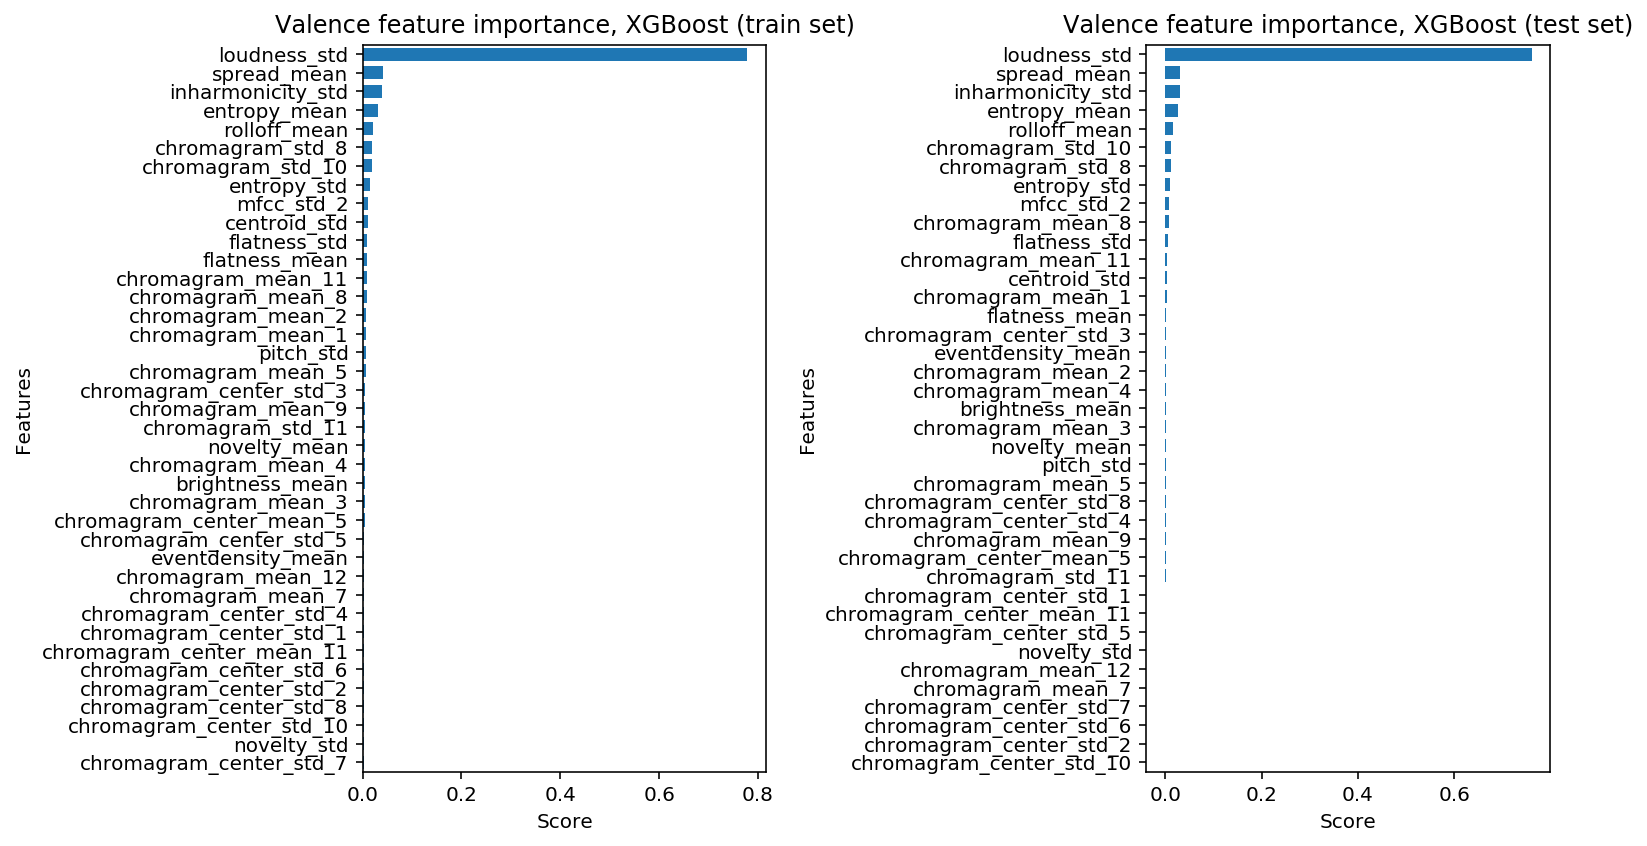

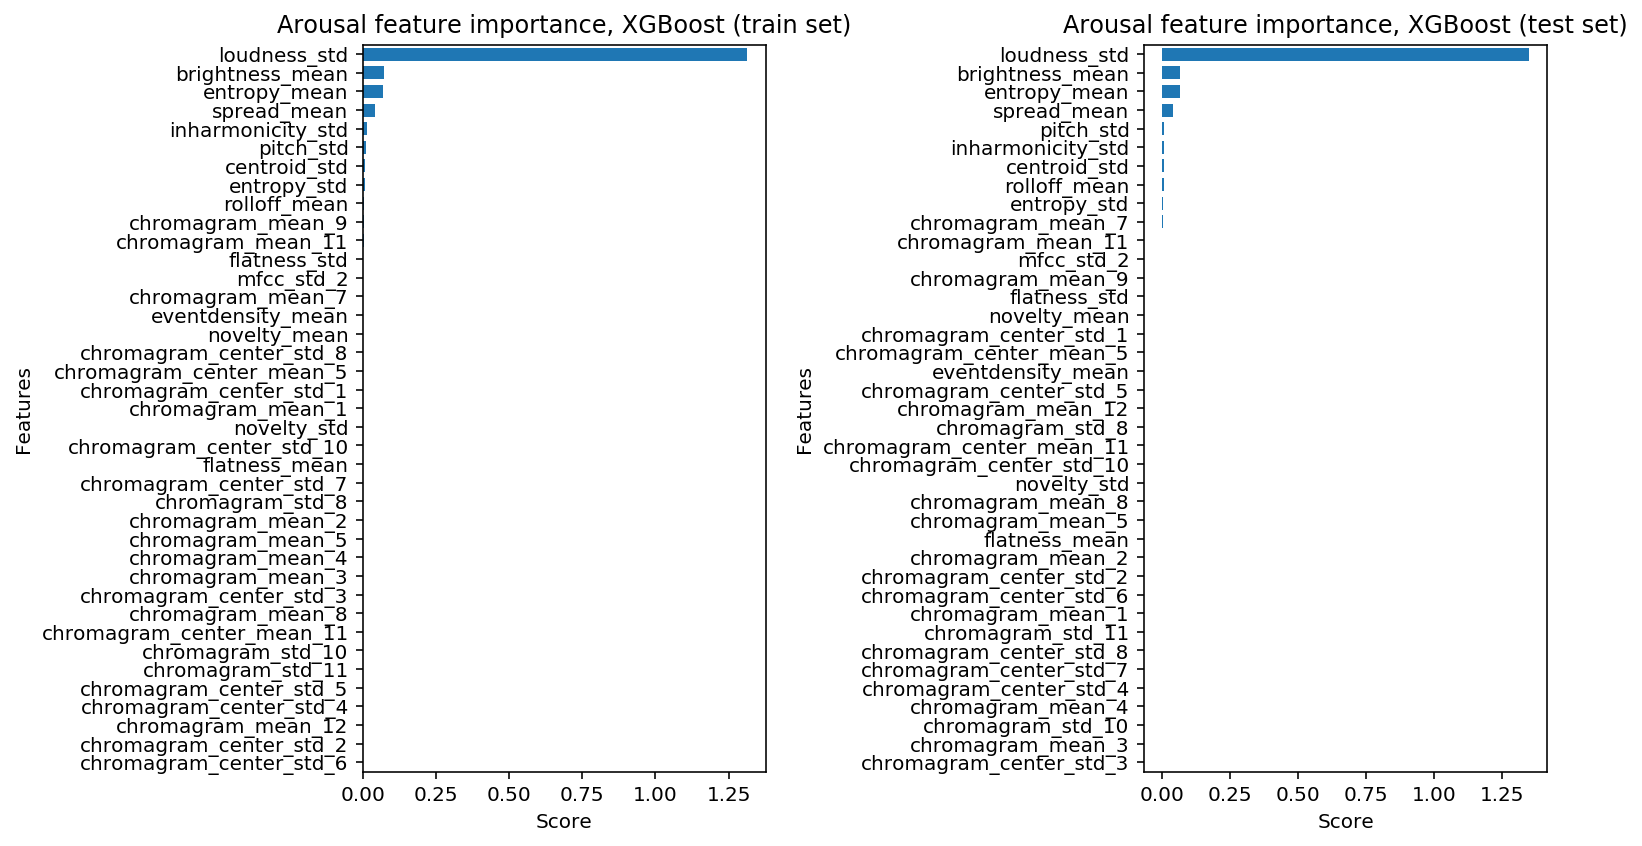

In [37]:
importance_sorted_idx_train_valence_XGB = np.argsort(final_feature_importance_train_valence_XGB)
indices_train_valence_XGB = np.arange(0, len(final_feature_importance_train_valence_XGB)) + 0.5

importance_sorted_idx_test_valence_XGB = np.argsort(final_feature_importance_test_valence_XGB)
indices_test_valence_XGB = np.arange(0, len(final_feature_importance_test_valence_XGB)) + 0.5


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(11, 6))
ax1.barh(indices_train_valence_XGB,
         final_feature_importance_train_valence_XGB[importance_sorted_idx_train_valence_XGB], height=0.7)

ax1.set_yticklabels(XData.columns[importance_sorted_idx_train_valence_XGB])
ax1.set_yticks(indices_train_valence_XGB)
ax1.set_ylim((0, len(final_feature_importance_train_valence_XGB)))
ax1.set_ylabel("Features")
ax1.set_xlabel("Score")
ax1.set_title("Valence feature importance, XGBoost (train set)")

ax2.barh(indices_test_valence_XGB,
         final_feature_importance_test_valence_XGB[importance_sorted_idx_test_valence_XGB], height=0.7)
ax2.set_yticklabels(XData.columns[importance_sorted_idx_test_valence_XGB])
ax2.set_yticks(indices_test_valence_XGB)
ax2.set_ylim((0, len(final_feature_importance_test_valence_XGB)))
ax2.set_ylabel("Features")
ax2.set_xlabel("Score")
ax2.set_title("Valence feature importance, XGBoost (test set)")
fig.tight_layout()
plt.show()

importance_sorted_idx_train_arousal_XGB = np.argsort(final_feature_importance_train_arousal_XGB)
indices_train_arousal_XGB = np.arange(0, len(final_feature_importance_train_arousal_XGB)) + 0.5

importance_sorted_idx_test_arousal_XGB = np.argsort(final_feature_importance_test_arousal_XGB)
indices_test_arousal_XGB = np.arange(0, len(final_feature_importance_test_arousal_XGB)) + 0.5

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(11, 6))
ax1.barh(indices_train_arousal_XGB,
         final_feature_importance_train_arousal_XGB[importance_sorted_idx_train_arousal_XGB], height=0.7)

ax1.set_yticklabels(XData.columns[importance_sorted_idx_train_arousal_XGB])
ax1.set_yticks(indices_train_arousal_XGB)
ax1.set_ylim((0, len(final_feature_importance_train_arousal_XGB)))
ax1.set_ylabel("Features")
ax1.set_xlabel("Score")
ax1.set_title("Arousal feature importance, XGBoost (train set)")

ax2.barh(indices_test_arousal_XGB,
         final_feature_importance_test_arousal_XGB[importance_sorted_idx_test_arousal_XGB], height=0.7)
ax2.set_yticklabels(XData.columns[importance_sorted_idx_test_arousal_XGB])
ax2.set_yticks(indices_test_arousal_XGB)
ax2.set_ylim((0, len(final_feature_importance_test_arousal_XGB)))
ax2.set_ylabel("Features")
ax2.set_xlabel("Score")
ax2.set_title("Arousal feature importance, XGBoost (test set)")
fig.tight_layout()
plt.show()

The subsets of the most important features are created based on the results of the previous graphs:

In [38]:
XData_10_features_valence_XGB = ['loudness_std','spread_mean','inharmonicity_std',
                                 'entropy_mean','rolloff_mean','chromagram_std_10',
                                 'chromagram_std_8','entropy_std','mfcc_std_2','chromagram_mean_8']

XData_5_features_valence_XGB = ['loudness_std','spread_mean','inharmonicity_std',
                                'entropy_mean','rolloff_mean']

XData_10_features_arousal_XGB = ['loudness_std','brightness_mean','entropy_mean',
                                'spread_mean','pitch_std','inharmonicity_std',
                                'centroid_std','rolloff_mean','entropy_std' ,'chromagram_mean_7' ]

XData_5_features_arousal_XGB = ['loudness_std','brightness_mean','entropy_mean',
                                'spread_mean','pitch_std']

### XGBoost with the 10 most important features

In [39]:


R2_valence_XGB_10F = []
MSE_valence_XGB_10F = []
R2_arousal_XGB_10F = []
MSE_arousal_XGB_10F = []
start = time.time()
iteration = 0

for train_index, test_index in Kfolds_cv2.split(XData):

 
    print("ITERATION: ", iteration)
    
    X_train_XGB, X_test_XGB = XData.iloc[train_index,:], XData.iloc[test_index,:]
    
    X_train_valence_XGB, X_test_valence_XGB = X_train_XGB.loc[:,XData_10_features_valence_XGB], X_test_XGB.loc[:,XData_10_features_valence_XGB]
    X_train_arousal_XGB, X_test_arousal_XGB = X_train_XGB.loc[:,XData_10_features_arousal_XGB], X_test_XGB.loc[:,XData_10_features_arousal_XGB]
    
    y_train_valence_XGB, y_test_valence_XGB = YvalenceXGB.iloc[train_index,:],  YvalenceXGB.iloc[test_index , :]
    y_train_arousal_XGB, y_test_arousal_XGB = YarousalXGB.iloc[train_index,:],  YarousalXGB.iloc[test_index, :]
    
    print("X train valence shape: " , X_train_valence_XGB.shape)
    print("X test valence shape: " , X_test_valence_XGB.shape)
    print("X train arousal shape: " , X_train_arousal_XGB.shape)
    print("X test arousal shape: " , X_test_arousal_XGB.shape)
    
    #VALENCE
    CV_XGB_valence = GridSearchCV( estimator = XGBRegressor(objective= 'reg:squarederror', nthread=-1, 
                                  scale_pos_weight=1,seed=42) , param_grid=param_grid_valence_XGB, 
                                  cv= Kfolds_cv , n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_XGB_valence.fit(X_train_XGB, y_train_valence_XGB.iloc[:,1] )

    XGB_final_valence = CV_XGB_valence.best_estimator_

    XGB_y_predicted_valence = XGB_final_valence.predict(X_test_XGB)

    
    R2score = r2_score(y_test_valence_XGB.iloc[:,1] , XGB_y_predicted_valence) 
    MSEscore = mean_squared_error( y_test_valence_XGB.iloc[:,1] , XGB_y_predicted_valence)
    MSE_valence_XGB_10F.append(MSEscore)
    R2_valence_XGB_10F.append(R2score)
    
    print('Best params: {} '.format(CV_XGB_valence.best_params_))
    print("R2 score: " , R2score)
    
    #AROUSAL
    CV_XGB_arousal = GridSearchCV( estimator = XGBRegressor(objective= 'reg:squarederror', nthread=-1, 
                                  scale_pos_weight=1,seed=42) , param_grid=param_grid_arousal_XGB,
                                  cv= Kfolds_cv ,  n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_XGB_arousal.fit(X_train_XGB, y_train_arousal_XGB.iloc[:,1] )

    XGB_final_arousal = CV_XGB_arousal.best_estimator_

    XGB_y_predicted_arousal = XGB_final_arousal.predict(X_test_XGB)

    
    R2score = r2_score(y_test_arousal_XGB.iloc[:,1] , XGB_y_predicted_arousal)
    MSEscore = mean_squared_error(y_test_arousal_XGB.iloc[:,1] , XGB_y_predicted_arousal)
    MSE_arousal_XGB_10F.append(MSEscore)
    R2_arousal_XGB_10F.append(R2score)
    print('Best params: {} '.format( CV_XGB_arousal.best_params_))
    print("R2 score: " , R2score)
    iteration = iteration +1

    
print("Time (minutes):")
print((time.time()-start)/60)
print("\n")

ITERATION:  0
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.795, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 55, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.7} 
R2 score:  0.6649878469120638
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.95, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.01, 'subsample': 0.85} 
R2 score:  0.8863046351772883
ITERATION:  1
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.795, 'gamma': 0.43619, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 70, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.8} 
R2 score:  0.668874463505461
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.898, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'reg_alpha': 0.0001, 'subsample': 0.755} 
R2 score:  0.8722397350763995
ITERATION:  2
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 63, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.9} 
R2 score:  0.6410995062164282
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.95, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'reg_alpha': 0.0001, 'subsample': 0.7} 
R2 score:  0.9031514279282173
ITERATION:  3
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 63, 'n_estimators': 67, 'reg_alpha': 1e-13, 'subsample': 0.9} 
R2 score:  0.643416883135596
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 92, 'reg_alpha': 0.0001, 'subsample': 0.7} 
R2 score:  0.885796613521377
ITERATION:  4
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 55, 'n_estimators': 80, 'reg_alpha': 1e-15, 'subsample': 0.8} 
R2 score:  0.6914214476710719
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 92, 'reg_alpha': 0.001, 'subsample': 0.755} 
R2 score:  0.9028369092515214
ITERATION:  5
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 63, 'n_estimators': 60, 'reg_alpha': 1e-13, 'subsample': 0.9} 
R2 score:  0.6899356064992556
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.898, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0.01, 'subsample': 0.7} 
R2 score:  0.8859838955900852
ITERATION:  6
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 63, 'n_estimators': 80, 'reg_alpha': 1e-15, 'subsample': 0.9} 
R2 score:  0.6213620838609848
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 92, 'reg_alpha': 0.0001, 'subsample': 0.7} 
R2 score:  0.899809565305296
ITERATION:  7
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 55, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.7} 
R2 score:  0.7277038296769816
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.898, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 85, 'reg_alpha': 0.0001, 'subsample': 0.755} 
R2 score:  0.8822935913369888
ITERATION:  8
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 63, 'n_estimators': 67, 'reg_alpha': 1e-15, 'subsample': 0.7} 
R2 score:  0.7122620674351349
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.898, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 92, 'reg_alpha': 0.001, 'subsample': 0.85} 
R2 score:  0.8702232815797627
ITERATION:  9
X train valence shape:  (970, 10)
X test valence shape:  (243, 10)
X train arousal shape:  (970, 10)
X test arousal shape:  (243, 10)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.795, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 63, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.7} 
R2 score:  0.7029207759106112
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.95, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 92, 'reg_alpha': 0.001, 'subsample': 0.7} 
R2 score:  0.8882538247242694
Time (minutes):
471.26253874699273




In [40]:
print("Valence R2 XGB: {0:.3f}".format(np.mean(R2_valence_XGB_10F)) + " std {0:.3f}".format(np.std(R2_valence_XGB_10F)))
print("Arousal R2 XGB: {0:.3f}".format(np.mean(R2_arousal_XGB_10F)) + " std {0:.3f}".format(np.std(R2_arousal_XGB_10F)))

print("Valence MSE XGB: {0:.3f}".format(np.mean(MSE_valence_XGB_10F)) + " std {0:.3f}".format(np.std(MSE_valence_XGB_10F)))
print("Arousal MSE XGB: {0:.3f}".format(np.mean(MSE_arousal_XGB_10F)) + " std {0:.3f}".format(np.std(MSE_arousal_XGB_10F)))

Valence R2 XGB: 0.676 std 0.033
Arousal R2 XGB: 0.888 std 0.011
Valence MSE XGB: 0.105 std 0.008
Arousal MSE XGB: 0.036 std 0.003


### XGBoost with the 5 most important features

In [41]:


R2_valence_XGB_5F = []
MSE_valence_XGB_5F = []
R2_arousal_XGB_5F = []
MSE_arousal_XGB_5F = []
start = time.time()
iteration = 0

for train_index, test_index in Kfolds_cv2.split(XData):

    print("ITERATION: " , iteration)
    
    X_train_XGB, X_test_XGB = XData.iloc[train_index,:], XData.iloc[test_index,:]
    
    X_train_valence_XGB, X_test_valence_XGB = X_train_XGB.loc[:,XData_5_features_valence_XGB], X_test_XGB.loc[:,XData_5_features_valence_XGB]
    X_train_arousal_XGB, X_test_arousal_XGB = X_train_XGB.loc[:,XData_5_features_arousal_XGB], X_test_XGB.loc[:,XData_5_features_arousal_XGB]
    
    y_train_valence_XGB, y_test_valence_XGB = YvalenceXGB.iloc[train_index,:],  YvalenceXGB.iloc[test_index , :]
    y_train_arousal_XGB, y_test_arousal_XGB = YarousalXGB.iloc[train_index,:],  YarousalXGB.iloc[test_index, :]
    
    print("X train valence shape: " , X_train_valence_XGB.shape)
    print("X test valence shape: " , X_test_valence_XGB.shape)
    print("X train arousal shape: " , X_train_arousal_XGB.shape)
    print("X test arousal shape: " , X_test_arousal_XGB.shape)
    
    #VALENCE
    CV_XGB_valence = GridSearchCV( estimator = XGBRegressor(objective= 'reg:squarederror', nthread=-1, 
                                  scale_pos_weight=1,seed=42) , param_grid=param_grid_valence_XGB, 
                                  cv= Kfolds_cv , n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_XGB_valence.fit(X_train_XGB, y_train_valence_XGB.iloc[:,1] )

    XGB_final_valence = CV_XGB_valence.best_estimator_

    XGB_y_predicted_valence = XGB_final_valence.predict(X_test_XGB)

    
    R2score = r2_score(y_test_valence_XGB.iloc[:,1] , XGB_y_predicted_valence) 
    MSEscore = mean_squared_error( y_test_valence_XGB.iloc[:,1] , XGB_y_predicted_valence)
    MSE_valence_XGB_5F.append(MSEscore)
    R2_valence_XGB_5F.append(R2score)
    
    print('Best params: {} '.format(CV_XGB_valence.best_params_))
    print("R2 score: " , R2score)
    
    #AROUSAL
    CV_XGB_arousal = GridSearchCV( estimator = XGBRegressor(objective= 'reg:squarederror', nthread=-1, 
                                  scale_pos_weight=1,seed=42) , param_grid=param_grid_arousal_XGB,
                                  cv= Kfolds_cv ,  n_jobs=-1, scoring = 'r2' , refit = 'r2' , verbose=True )

    CV_XGB_arousal.fit(X_train_XGB, y_train_arousal_XGB.iloc[:,1] )

    XGB_final_arousal = CV_XGB_arousal.best_estimator_

    XGB_y_predicted_arousal = XGB_final_arousal.predict(X_test_XGB)

    
    R2score = r2_score(y_test_arousal_XGB.iloc[:,1] , XGB_y_predicted_arousal)
    MSEscore = mean_squared_error(y_test_arousal_XGB.iloc[:,1] , XGB_y_predicted_arousal)
    MSE_arousal_XGB_5F.append(MSEscore)
    R2_arousal_XGB_5F.append(R2score)
    print('Best params: {} '.format( CV_XGB_arousal.best_params_))
    print("R2 score: " , R2score)
    iteration = iteration +1

    
print("Time (minutes):")
print((time.time()-start)/60)
print("\n")

ITERATION:  0
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.795, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 55, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.7} 
R2 score:  0.6649878469120638
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.95, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.01, 'subsample': 0.85} 
R2 score:  0.8863046351772883
ITERATION:  1
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.795, 'gamma': 0.43619, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 70, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.8} 
R2 score:  0.668874463505461
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.898, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'reg_alpha': 0.0001, 'subsample': 0.755} 
R2 score:  0.8722397350763995
ITERATION:  2
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 63, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.9} 
R2 score:  0.6410995062164282
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.95, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'reg_alpha': 0.0001, 'subsample': 0.7} 
R2 score:  0.9031514279282173
ITERATION:  3
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 63, 'n_estimators': 67, 'reg_alpha': 1e-13, 'subsample': 0.9} 
R2 score:  0.643416883135596
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 92, 'reg_alpha': 0.0001, 'subsample': 0.7} 
R2 score:  0.885796613521377
ITERATION:  4
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 55, 'n_estimators': 80, 'reg_alpha': 1e-15, 'subsample': 0.8} 
R2 score:  0.6914214476710719
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 92, 'reg_alpha': 0.001, 'subsample': 0.755} 
R2 score:  0.9028369092515214
ITERATION:  5
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 63, 'n_estimators': 60, 'reg_alpha': 1e-13, 'subsample': 0.9} 
R2 score:  0.6899356064992556
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.898, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0.01, 'subsample': 0.7} 
R2 score:  0.8859838955900852
ITERATION:  6
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 63, 'n_estimators': 80, 'reg_alpha': 1e-15, 'subsample': 0.9} 
R2 score:  0.6213620838609848
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.8, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 92, 'reg_alpha': 0.0001, 'subsample': 0.7} 
R2 score:  0.899809565305296
ITERATION:  7
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 55, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.7} 
R2 score:  0.7277038296769816
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.898, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 85, 'reg_alpha': 0.0001, 'subsample': 0.755} 
R2 score:  0.8822935913369888
ITERATION:  8
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 63, 'n_estimators': 67, 'reg_alpha': 1e-15, 'subsample': 0.7} 
R2 score:  0.7122620674351349
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.898, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 92, 'reg_alpha': 0.001, 'subsample': 0.85} 
R2 score:  0.8702232815797627
ITERATION:  9
X train valence shape:  (970, 5)
X test valence shape:  (243, 5)
X train arousal shape:  (970, 5)
X test arousal shape:  (243, 5)
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.795, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 63, 'n_estimators': 80, 'reg_alpha': 1e-13, 'subsample': 0.7} 
R2 score:  0.7029207759106112
Fitting 10 folds for each of 2187 candidates, totalling 21870 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best params: {'colsample_bytree': 0.95, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 92, 'reg_alpha': 0.001, 'subsample': 0.7} 
R2 score:  0.8882538247242694
Time (minutes):
499.24157657225925




In [42]:
print("Valence R2 XGB: {0:.3f}".format(np.mean(R2_valence_XGB_5F)) + " std {0:.3f}".format(np.std(R2_valence_XGB_5F)))
print("Arousal R2 XGB: {0:.3f}".format(np.mean(R2_arousal_XGB_5F)) + " std {0:.3f}".format(np.std(R2_arousal_XGB_5F)))

print("Valence MSE XGB: {0:.3f}".format(np.mean(MSE_valence_XGB_5F)) + " std {0:.3f}".format(np.std(MSE_valence_XGB_5F)))
print("Arousal MSE XGB: {0:.3f}".format(np.mean(MSE_arousal_XGB_5F)) + " std {0:.3f}".format(np.std(MSE_arousal_XGB_5F)))

Valence R2 XGB: 0.676 std 0.033
Arousal R2 XGB: 0.888 std 0.011
Valence MSE XGB: 0.105 std 0.008
Arousal MSE XGB: 0.036 std 0.003


### CNN

Audio: r_0quiet106869_1635617-hq.wav
Window size: 
1102
Step size: 
441


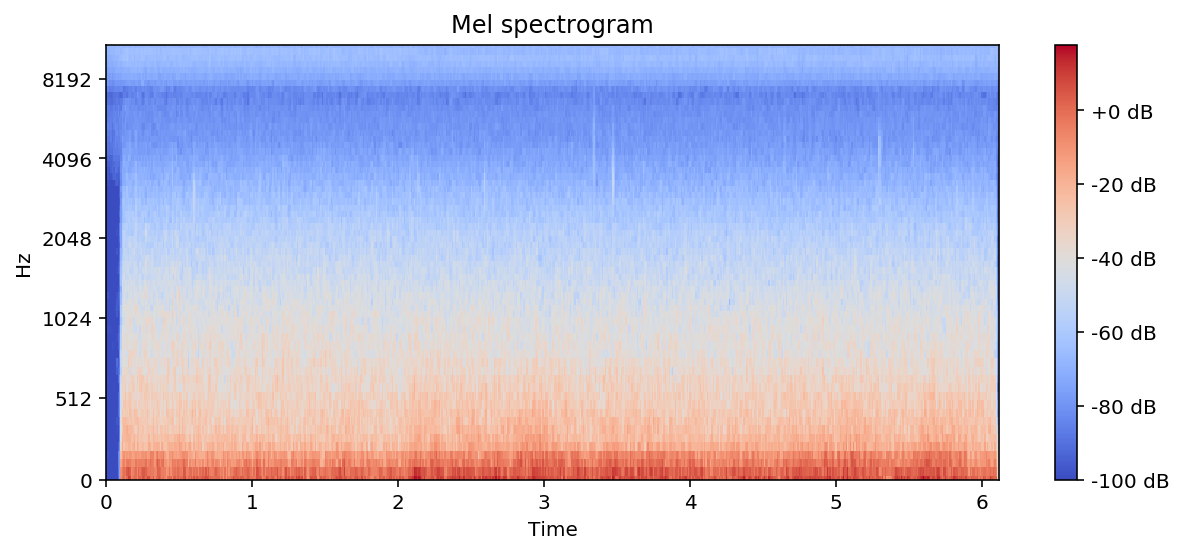

Audio: mix_between_quiet_society_5-12_5-6.wav
Window size: 
1200
Step size: 
480


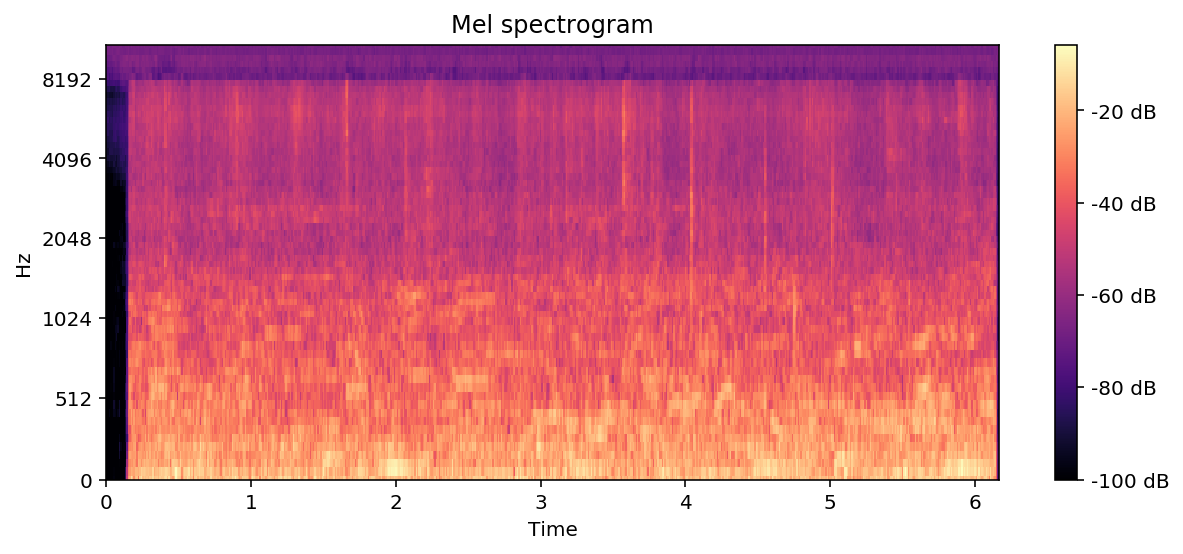

Audio: r_0quiet106869_1635617-hq.wav
Window size: 
1102
Step size: 
441


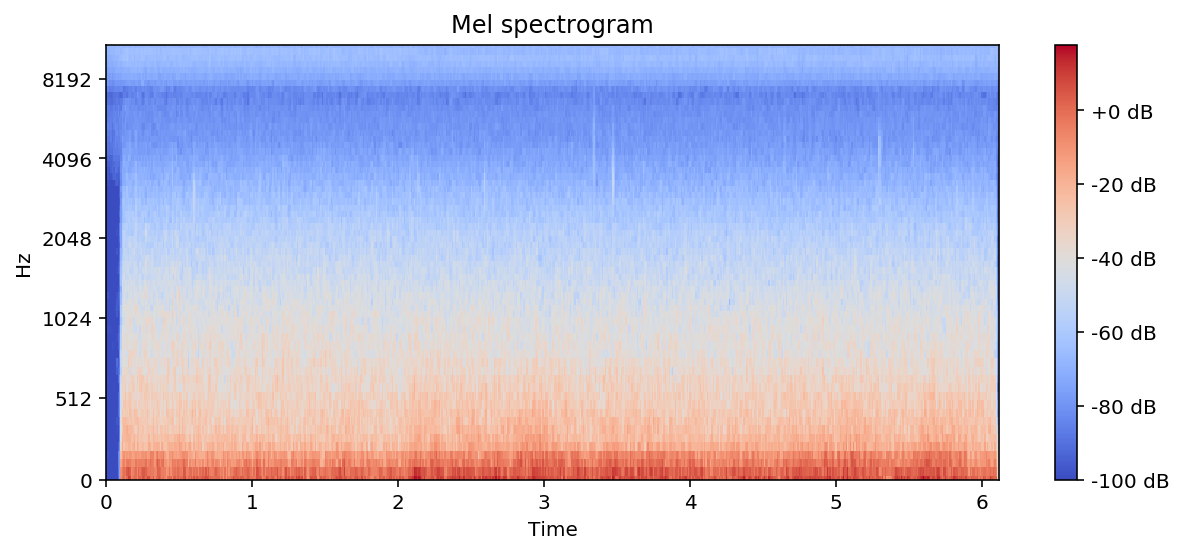

Audio: mix_between_quiet_society_5-12_5-6.wav
Window size: 
1200
Step size: 
480


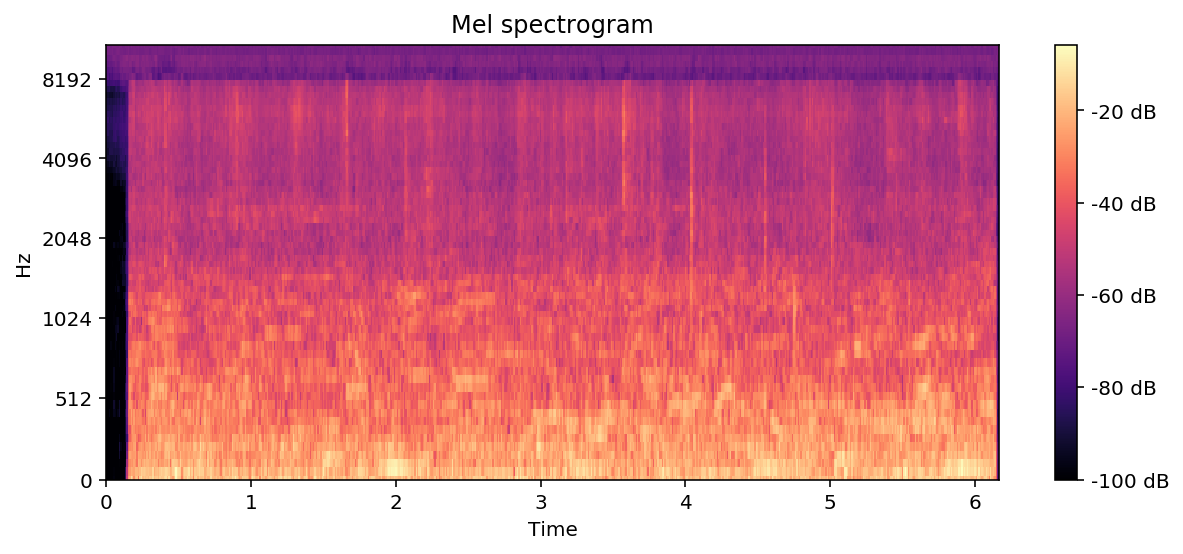

Data for the CNN


normalized pathes train valence shape: 
(5820, 64, 100, 1)
y train valence shape:
(5820,)
normalized pathes test valence shape: 
(1458, 64, 100, 1)
y test valence shape:
(1458,)
normalized pathes train arousal shape: 
(5820, 64, 100, 1)
y train arousal shape:
(5820,)
normalized pathes test arousal shape: 
(1458, 64, 100, 1)
y test arousal shape:
(1458,)


In [ ]:

#Function to find the full path of a file
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

#Function to compute the log-mel patches of the spectrograms
def getNormMelPatches(y_dataset):    
    
    wst = 25e-3;          # Window size (seconds), to apply the Fourier transformation in a 25 ms window
    fpt = 10e-3;          # Frame period (seconds)
    nbands = 64;          # Number of filters in the filterbank
    
    # Read the audio file
    i = 0
    normalized_pathes = []
    y_patches = []
    
    Audio_descriptors = y_dataset[:,0]
    y_values = y_dataset[:,1]
    row = 0
    
    for audio_name in Audio_descriptors:
    
        
        full_path = find(audio_name, "./Emo-Soundscapes")

        # Read the audio file
        x, fs = librosa.load(full_path, sr=None)

        # Compute mel-spectrogram from the raw signal
        nfft = round(wst*fs); # Window size (samples)
        fp = round(fpt*fs);   # Frame period (samples)
        melfb = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands)

        # Compute log-mel spectrogram
        logmelfb = librosa.core.power_to_db(melfb, top_db=None)

        patch1 = logmelfb[:,0:100]
        transformer1 =  Normalizer().fit(patch1)
        patch1 = transformer1.transform(patch1)
        normalized_pathes.append(patch1)
        y_patches.append(y_values[row])
        
        patch2 = logmelfb[:,100:200]
        transformer2 =  Normalizer().fit(patch2)
        patch2 = transformer2.transform(patch2)
        normalized_pathes.append(patch2)
        y_patches.append(y_values[row])
        
        patch3 = logmelfb[:,200:300]
        transformer3 =  Normalizer().fit(patch3)
        patch3 = transformer3.transform(patch3)
        normalized_pathes.append(patch3)
        y_patches.append(y_values[row])
        
        patch4 = logmelfb[:,300:400]
        transformer4 =  Normalizer().fit(patch4)
        patch4 = transformer4.transform(patch4)
        normalized_pathes.append(patch4)
        y_patches.append(y_values[row])

        patch5 = logmelfb[:,400:500]
        transformer5 =  Normalizer().fit(patch5)
        patch5 = transformer5.transform(patch5)
        normalized_pathes.append(patch5)
        y_patches.append(y_values[row])
        
        patch6 = logmelfb[:,500:600]
        transformer6 =  Normalizer().fit(patch6)
        patch6 = transformer6.transform(patch6)
        normalized_pathes.append(patch6)  
        y_patches.append(y_values[row])
        
        row = row + 1
        if i ==0:

            print("Audio: " + audio_name)
            print("Window size: ")
            print(nfft)
            print("Step size: ")
            print(fp)
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(logmelfb,sr=fs, hop_length=fp, y_axis='mel', x_axis='time')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Log-Mel spectrogram')
            plt.show()
            i = i+1
            
    return np.array(normalized_pathes), np.array(y_patches)
        







In [ ]:
#CNN architecture
def build_cnn(activation = 'softsign',
              dropout_rate = 0.5,
              optimizer = 'Adam',
              init_mode='glorot_uniform',
              kernel_size = 3,
              param1 = 4,
              param2 = 2,
              filters1 = 64,
              neurons = 32,
              filters2 = 16
             ):
    
    model = Sequential()
    model.add(Conv2D(filters = filters1, kernel_size = (kernel_size, kernel_size), activation='relu', input_shape = (64,100,1)))
    model.add(MaxPooling2D((param1,param2), strides=(param1,param2)))

    model.add(Conv2D(filters = filters2, kernel_size = (kernel_size, kernel_size), activation='relu'  ))

    model.add(MaxPooling2D((param1,param2), strides=(param1,param2)))
    
    model.add(Conv2D( filters = filters2 , kernel_size = (kernel_size, kernel_size),  activation='relu'))
    
    model.add(Flatten())
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    #Output layer
    model.add(Dense(1, activation = 'softsign' , kernel_initializer=init_mode))
    
    model.compile(optimizer='Adam', loss='mse')
    
    return model


In [ ]:
YvalenceCNN = pd.DataFrame(Yvalence) 
YarousalCNN = pd.DataFrame(Yarousal) 


R2_valence_CNN = []
MSE_valence_CNN = []
R2_arousal_CNN = []
MSE_arousal_CNN = []
start = time.time()


for train_index, test_index in Kfolds_cv2.split(XData):

 
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)

    X_train_CNN, X_test_CNN = XData.iloc[ train_index , :], XData.iloc[ test_index , : ]
    y_train_valence_CNN, y_test_valence_CNN = YvalenceCNN.iloc[train_index,:],  YvalenceCNN.iloc[test_index , :]
    y_train_arousal_CNN, y_test_arousal_CNN = YarousalCNN.iloc[train_index,:],  YarousalCNN.iloc[test_index, :]
    
    
    y_train_valence_CNN = y_train_valence_CNN.to_numpy()
    y_test_valence_CNN = y_test_valence_CNN.to_numpy()
    y_train_arousal_CNN = y_train_arousal_CNN.to_numpy()
    y_test_arousal_CNN = y_test_arousal_CNN.to_numpy()

    normalized_pathes_train_valence, y_patches_train_valence = getNormMelPatches(y_train_valence_CNN)
    normalized_pathes_test_valence, y_patches_test_valence = getNormMelPatches(y_test_valence_CNN)
    normalized_pathes_train_arousal, y_patches_train_arousal = getNormMelPatches(y_train_arousal_CNN)
    normalized_pathes_test_arousal, y_patches_test_arousal = getNormMelPatches(y_test_arousal_CNN)
    
    normalized_pathes_train_valence = normalized_pathes_train_valence.reshape((5820, 64, 100, 1))
    normalized_pathes_test_valence = normalized_pathes_test_valence.reshape((1458, 64, 100, 1))
    normalized_pathes_train_arousal = normalized_pathes_train_arousal.reshape((5820, 64, 100, 1))
    normalized_pathes_test_arousal = normalized_pathes_test_arousal.reshape((1458, 64, 100, 1))
    
    #VALENCE
    model_CNN_valence = KerasRegressor(build_fn = build_cnn, verbose=True, epochs=53, batch_size=32)

    history_valence = model_CNN_valence.fit(normalized_pathes_train_valence, y_patches_train_valence)
    
    CNN_y_predicted_valence = model_CNN_valence.predict(normalized_pathes_test_valence)

    MSE_valence_CNN.append( mean_squared_error( y_patches_test_valence, CNN_y_predicted_valence) )
    R2_valence_CNN.append( r2_score(y_patches_test_valence , CNN_y_predicted_valence) )
    
    #AROUSAL
    model_CNN_arousal = KerasRegressor(build_fn = build_cnn, verbose=True, epochs=53, batch_size=32)

    history_valence = model_CNN_arousal.fit(normalized_pathes_train_arousal, y_patches_train_arousal)

    CNN_y_predicted_arousal = model_CNN_arousal.predict(normalized_pathes_test_arousal)

    MSE_arousal_CNN.append(mean_squared_error(y_patches_test_arousal , CNN_y_predicted_arousal))
    R2_arousal_CNN.append(r2_score(y_patches_test_arousal , CNN_y_predicted_arousal))


    
    
print("Time (minutes):")
print((time.time()-start)/60)
print("\n")

In [ ]:
print("Valence R2 CNN: {0:.3f}".format(np.mean(R2_valence_CNN)) + " std {0:.3f}".format(np.std(R2_valence_CNN)))
print("Arousal R2 CNN: {0:.3f}".format(np.mean(R2_arousal_CNN)) + " std {0:.3f}".format(np.std(R2_arousal_CNN)))


print("Valence MSE CNN: {0:.3f}".format(np.mean(MSE_valence_CNN)) + " std {0:.3f}".format(np.std(MSE_valence_CNN)))
print("Arousal MSE CNN: {0:.3f}".format(np.mean(MSE_arousal_CNN)) + " std {0:.3f}".format(np.std(MSE_arousal_CNN)))

In [ ]:
model = KerasRegressor(build_fn = build_cnn_PAPER, verbose=True, epochs=53, batch_size=32)

param_grid = {
               #'kernel_size': [1,3,5],
               #'filters1': [16,32,64],
               #'filters2': [16,32,64],
               #'param1': [1,2,3,4],
               #'param2': [1,2,3,4]
              #'epochs':     [1000],
              #'neurons' : [32,64,128],
              #'batch_size':  [10, 20, 40, 60, 80, 100],
              #'weight_constraint' : [1,2,3,4,5],
              #'optimizer':   ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
              'dropout_rate':[0.1,0.3,0.5],
              #'activation':  ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
              #'init_mode':   ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
              #'learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3],
              #'momentum' : [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
             }

gridsearchModel = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        scoring='r2',
        cv=5,
        refit='r2',
        verbose=True,
        n_jobs=-1
        )


gridsearchModel.fit(normalized_pathes_train_valence, y_patches_train_valence)

print("Best: %f using %s" % (gridsearchModel.best_score_, gridsearchModel.best_params_))

(5820, 64, 100, 1)
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
